### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

#physical_devices = tf.config.experimental.list_physical_devices()
#tf.config.experimental.set_memory_growth(physical_devices[2], True)

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000022AC6EBC1F0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 9: Convolutional Neural Network (2D)

***

- The paper entitled "ESC-ConvNet: Environmental Sound Classification with Convolutional Neural Networks" (PICZAK, 2015) serves as the foundation for the following analysis. In this study, the author employs Convolutional Neural Networks (CNNs) for image classification, utilizing fixed dimension images that consist of multiple channels (such as RGB for color images). The network undergoes various stages of convolution, pooling, and fully connected layers, ultimately outputting class probabilities for the given image. With the aim to replicate this approach using sound clips, the utilization of log-scaled mel-spectrograms and their respective deltas from each sound clip is proposed instead of directly using the sound file as an amplitude vs. time signal. In order to address the requirement of fixed size input, the sound clips are segmented into 60x41 segments (60 bands and 44 frames - windowing techinique). The log-scaled mel-spectrograms are extracted from all the recordings, which were resampled to 22050 Hz and normalized with a window size of 1024, a hop length of 512, and 60 mel-bands.

- The human auditory system perceives sound on a logarithmic scale, rendering it difficult to distinguish closely-scaled frequencies. This effect becomes more pronounced with increasing frequency. Therefore, only the power within different frequency bands is considered. As a result, the mel-spectrograms and their corresponding deltas are transformed into two channels that are subsequently inputted into the CNN for analysis.

- During the iterative process of file exploration, it was noticed that each sound is 4, 5 or 10 seconds in duration and has in its duration (sometimes) silent periods. In order to achieve a more representative "sound image", for each sound, the "extract_feature" methods are utilized to trim the silent periods and duplicate the sound, effectively doubling its trimmed length (augmented audio). Subsequently, the aforementioned features, along with the class labels, are calculated and appended to arrays.

- The final result transformed the audio file into a spectrogram image consisting of 60 bands, 44 frames, and 2 channels. After a few cross-validations, it was confirmed the accuracy has improved when the deltas are aggreated to the image instead of using them as channels, therefore, the final image dimension was 180 (60 mels, 60 delta 1 and 60 delta 2) x 44 frames. 

## Import modules

In [2]:
import librosa
import librosa.display
import os
import warnings
import pickle
import itertools
import mimetypes
import time

import pandas     as pd
import seaborn    as sns
import numpy      as np

from matplotlib  import pyplot  as plt
from keras       import backend as K

from tqdm                        import tqdm

from sklearn                     import metrics
from sklearn.model_selection     import train_test_split
from sklearn.metrics             import confusion_matrix, classification_report

from tensorflow                  import keras
from tensorflow.keras.models     import Sequential, load_model
from tensorflow.keras.layers     import Dense, Dropout, Flatten, InputLayer, Conv2D
from tensorflow.keras.layers     import MaxPooling2D, BatchNormalization, Activation

from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks             import ModelCheckpoint, EarlyStopping
from keras.optimizers            import SGD
from keras.constraints           import maxnorm

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '09_CNN_2D_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

## Loading the dataset

In [4]:
# Select the dataset

opcD = 0
while str(opcD) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")

    opcD = input("\nSelect the dataset: ")
    if opcD.isdigit():
        opcD = int(opcD)
    else:
        opcD = 0

if opcD == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = 1
    dog_set     = 'Dog bark'
    
    pkl_features_CNN_2D          = 'ESC-10_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'ESC-10_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'ESC-10_features_CNN_2D_augmented.pkl'
    

    
if opcD == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'
    dog_set     = 'dogs'
    
    pkl_features_CNN_2D          = 'BDLib2_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'BDLib2_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'BDLib2_features_CNN_2D_augmented.pkl'
    
    
if opcD == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
        
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    dog_set     = 'dog_bark'

    pkl_features_CNN_2D          = 'US8K_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'US8K_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'US8K_features_CNN_2D_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    
    
if opcD == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)


    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'
    dog_set     = 'dog_bark'
    
    pkl_features_CNN_2D          = 'US8K_AV_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'US8K_AV_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'US8K_AV_features_CNN_2D_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [5]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [6]:
from MT_loadDataset import loadDataset

In [7]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
silence              550
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4908
Total number of AUDIO files...........:  4908


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path
0,5,fold5,"[0, 0, 0, 1, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav
1,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav
2,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav
3,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav
4,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav
...,...,...,...,...,...,...
4903,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-10.wav
4904,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-11.wav
4905,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-12.wav
4906,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192-10-0-8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\fold9\708192-10-0-8.wav


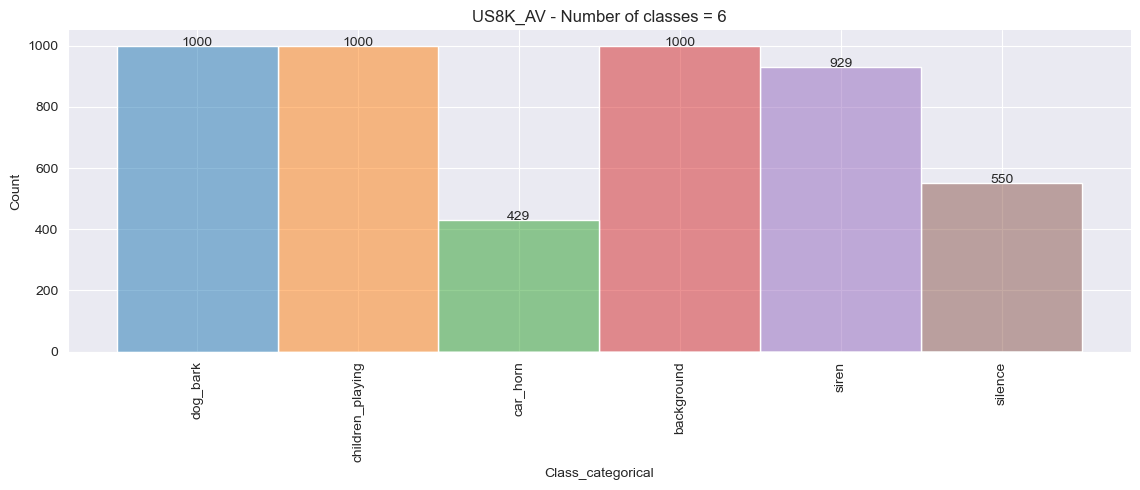

In [8]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [9]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K is only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_features_CNN_2D))
    model_surname    = '_original'

elif opc == 2:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_aug_features_CNN_2D))
    model_surname    = '_augmented'

elif opc == 3:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features_CNN_2D))
    model_surname    = '_windowed'
    
else:
    pass


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K is only windowed)

Select the dataset: 3


In [10]:
DB_from_pkl

,Class_categorical,Class_OHEV,Fold,features
0,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-44.0467643737793], [-39.25644302368164], [-38.62413787841797], [-36.58848571777344], [-32.5598030090332], [-31.4..."
1,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-29.934663772583008], [-34.787696838378906], [-40.06871795654297], [-41.22150802612305], [-41.03109359741211], [-..."
2,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-23.2158260345459], [-28.396337509155273], [-32.66521072387695], [-31.442462921142578], [-35.61741256713867], [-3..."
3,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-37.06025695800781], [-39.86629104614258], [-41.0966682434082], [-38.97296142578125], [-41.87018966674805], [-39...."
4,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-28.527423858642578], [-29.930322647094727], [-35.48342514038086], [-38.032806396484375], [-38.82895278930664], [..."
...,...,...,...,...
34351,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-28.725196838378906], [-21.75506591796875], [-15.691794395446777], [-11.686802864074707], [-13.252153396606445], ..."
34352,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-18.317378997802734], [-14.795974731445312], [-13.88856315612793], [-13.34511947631836], [-14.05569076538086], [-..."
34353,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-14.710319519042969], [-12.146648406982422], [-13.191940307617188], [-14.210320472717285], [-15.148565292358398],..."
34354,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-26.25575828552246], [-20.983177185058594], [-14.533549308776855], [-15.130903244018555], [-16.879596710205078], ..."


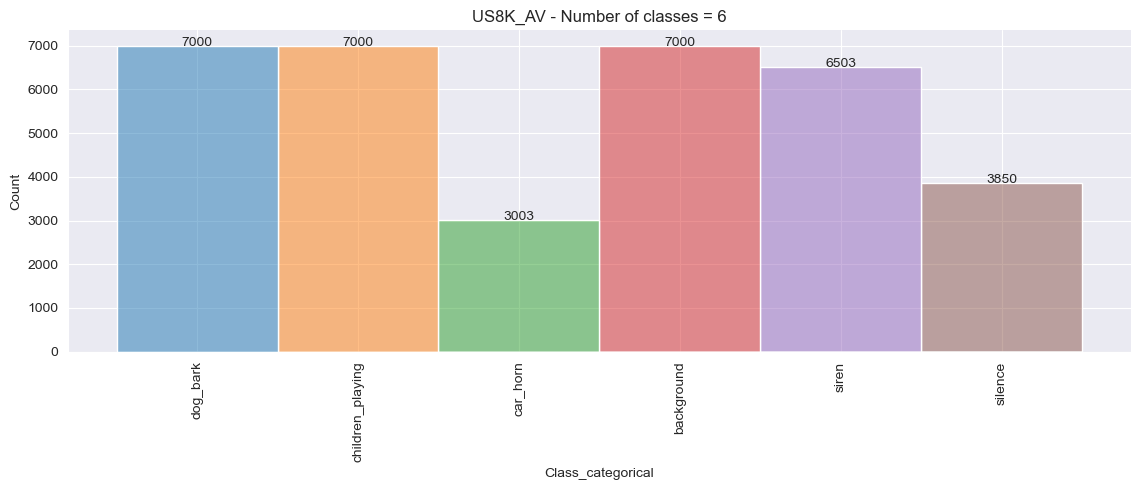

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [12]:
for fold in np.unique(DB_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_from_pkl[DB_from_pkl['Fold'] == fold])
    trnsize = len(DB_from_pkl[DB_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete_TRN size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 3346
dbComplete_TRN size: 31010

Validation fold: 10
dbComplete_VAL size: 3276
dbComplete_TRN size: 31080

Validation fold: 2
dbComplete_VAL size: 3395
dbComplete_TRN size: 30961

Validation fold: 3
dbComplete_VAL size: 3752
dbComplete_TRN size: 30604

Validation fold: 4
dbComplete_VAL size: 4193
dbComplete_TRN size: 30163

Validation fold: 5
dbComplete_VAL size: 3703
dbComplete_TRN size: 30653

Validation fold: 6
dbComplete_VAL size: 3220
dbComplete_TRN size: 31136

Validation fold: 7
dbComplete_VAL size: 3255
dbComplete_TRN size: 31101

Validation fold: 8
dbComplete_VAL size: 3087
dbComplete_TRN size: 31269

Validation fold: 9
dbComplete_VAL size: 3129
dbComplete_TRN size: 31227



In [13]:
if opcD == 1:
    fold = 1
    
elif opcD == 2:
    fold = 'fold-1'

elif opcD == 3:
    fold = '1'

elif opcD == 4:
    fold = '1'

else:
    print("How did you manage to get this option?!")

print(fold)

1


In [14]:
DB_from_pkl.dtypes

Class_categorical    object
Class_OHEV           object
Fold                 object
features             object
dtype: object

In [15]:
DB_from_pkl['Class_OHEV'][0][0]

0

In [16]:
print(DB_from_pkl['Fold'].shape)
print(DB_from_pkl['Class_OHEV'][0].shape)
print(DB_from_pkl['features'][0].shape)

(34356,)
(6,)
(180, 44, 1)


In [17]:
print(type(DB_from_pkl['Fold'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0][0]))
print(type(DB_from_pkl['features'][0][0][0][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.float64'>


In [18]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         12695    [1, 0, 0, 0, 0, 0]
car_horn           26793    [0, 1, 0, 0, 0, 0]
children_playing   4676     [0, 0, 1, 0, 0, 0]
dog_bark           1810     [0, 0, 0, 1, 0, 0]
silence            34205    [0, 0, 0, 0, 1, 0]
siren              19164    [0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0]),
 'silence': array([0, 0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 0, 1])}

In [19]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

6

In [20]:
# Name of the classes

nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'silence', 'siren']

## Input split

In [21]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

X      = DB_from_pkl_TRN['features'].to_numpy()
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

X_val      = DB_from_pkl_VAL['features'].to_numpy()
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())


# Stackup and pass all values to float32
X = np.stack(X)
X = np.asarray(X).astype(np.float32)

X_val = np.stack(X_val)
X_val = np.asarray(X_val).astype(np.float32)

y_OHEV     = np.asarray(y_OHEV).astype(np.float32)
y_OHEV_val = np.asarray(y_OHEV_val).astype(np.float32)


# Retrieve the indexes used for training the classifiers
idx_trn = np.genfromtxt(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)
idx_tst = np.genfromtxt(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)

X_train      = X[idx_trn]
X_test       = X[idx_tst]
y_train      = y[idx_trn]
y_test       = y[idx_tst]
y_train_OHEV = y_OHEV[idx_trn]
y_test_OHEV  = y_OHEV[idx_tst]

In [22]:
idx_trn

array([ 1407, 16859,  5412, ...,  3926, 15590, 24914])

In [23]:
idx_tst

array([ 6025, 24431, 11398, ..., 30565, 25076, 10536])

In [24]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val...........: {np.shape(X_val)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (27909, 180, 44, 1)
y_train.........: (27909,)
y_train_OHEV....: (27909, 6)

Testing set

X_test..........: (3101, 180, 44, 1)
y_test..........: (3101,)
y_test_OHEV.....: (3101, 6)

Validation set

X_val...........: (3346, 180, 44, 1)
y_val...........: (3346,)
y_OHEV_val......: (3346, 6)


In [25]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [26]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

## Classifiers

- **Convolutional Neural Networks** (CNNs) are a class of deep learning algorithms specifically designed for processing grid-like data, such as images and videos. CNNs are highly effective in tasks related to computer vision, including image recognition, object detection, and image segmentation. They are characterized by their ability to automatically and adaptively learn spatial hierarchies of features from input data. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers apply convolution operations to the input data, enabling the network to automatically learn patterns and features from images, such as edges, textures, and more complex structures. The pooling layers downsample the spatial dimensions of the data, reducing computational complexity while retaining important features. Fully connected layers at the end of the network process the learned features and make predictions based on them. One of the significant advantages of CNNs is their ability to capture local patterns and spatial hierarchies of features. By using shared weights and biases in the convolutional layers, CNNs are capable of learning translation-invariant features, making them well-suited for tasks where the spatial arrangement of features in the input data is essential. Additionally, CNNs can automatically learn relevant features from raw pixel values, eliminating the need for manual feature extraction.

In [27]:
inputShape = X_train[0].shape
inputShape

(180, 44, 1)

In [28]:
# Architecture based on Su et al. (2019)

def basemodel_Su(model_name):
       
    model = Sequential(name = model_name)
    
    # Input is 44 x 180
    # If we have N x N image size and F x F filter size, afer the convolution the result will be
    # (N x N) * (F x F) = (N - F + 1) x (N - F + 1)
    # (44 - 7 + 1) x (180 - 7 + 1) = (38 x 174)
    
    model.add(Conv2D(32, (3, 3), input_shape=(inputShape), padding='same', strides=(2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten(name='Flatten'))

    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs  = 100
    lrate   = 0.001
    decay   = lrate/epochs
    sgd     = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [29]:
# Architecture based on Luz et al. (2021)

def basemodel_Luz(model_name):
       
    model = Sequential(name = model_name)
    
    model.add(Conv2D(24, (5, 5), input_shape=(inputShape), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten(name='Flatten'))

    model.add(Dense(64, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs  = 100
    lrate   = 0.001
    decay   = lrate/epochs
    sgd     = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [30]:
monitor = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)

filepath       = os.path.join(path_models, 'Model_CNN_2D_weights_0_best' + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, monitor]

In [31]:
# Select the model

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Architecture based on Su et al. (2019)")
    print("2-) Architecture based on Luz et al. (2021)")

    opc = input("\nSelect the model: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    basemodel = basemodel_Su
    surName = '_Su'

elif opc == 2:
    basemodel = basemodel_Luz
    surName = '_Luz'

else:
    pass

Model_CNN_2D = basemodel('Model_CNN_2D' + surName)
print(Model_CNN_2D.summary())


1-) Architecture based on Su et al. (2019)
2-) Architecture based on Luz et al. (2021)

Select the model: 1
Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
________

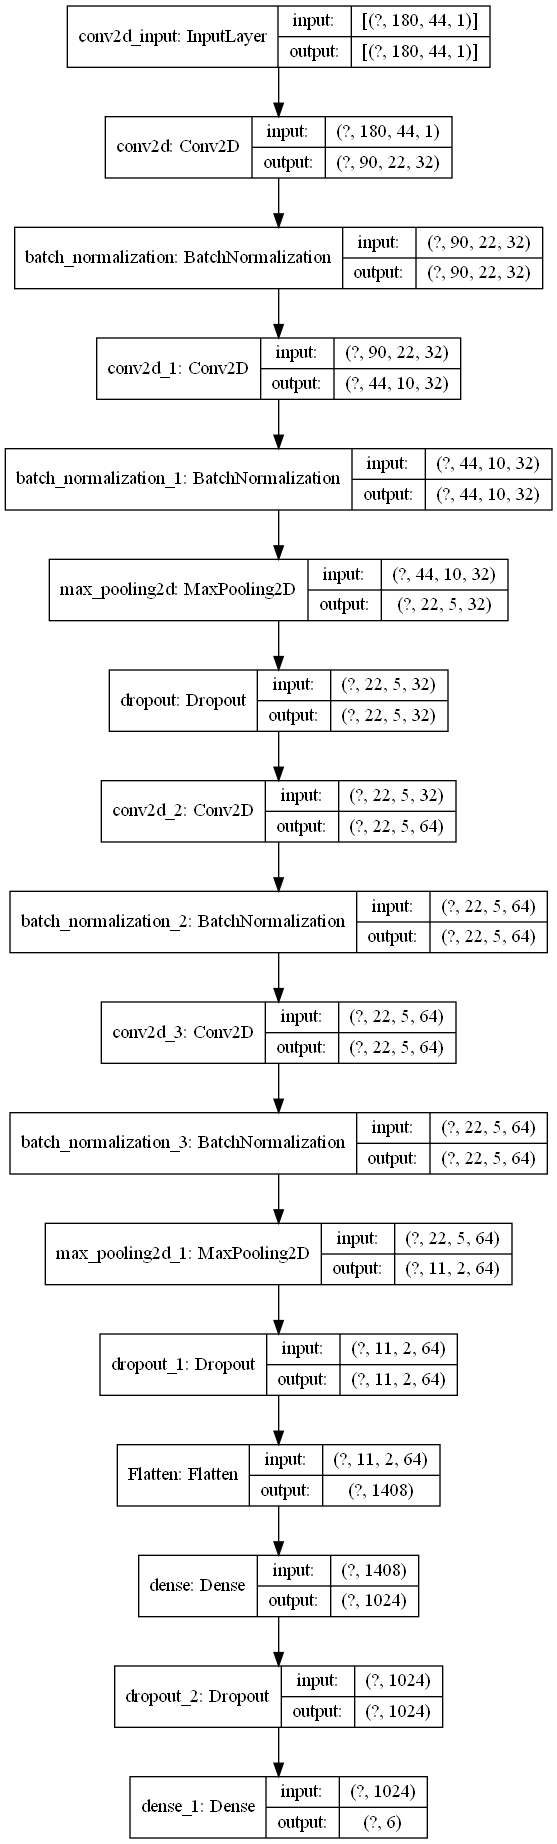

In [32]:
tf.keras.utils.plot_model(Model_CNN_2D, to_file= os.path.join(path_models, 'Model_CNN_2D' + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

1. For `Conv1D` layer:
   - The number of parameters for a `Conv1D` layer is calculated as `(kernel_size * input_channels + 1) * output_channels`, where `kernel_size` is the size of the convolutional kernel, `input_channels` is the number of input channels (1 in this case), and `output_channels` is the number of output channels.

2. For `Dense` layer:
   - The number of parameters for a `Dense` layer is calculated as `(input_units + 1) * output_units`, where `input_units` is the number of input units and `output_units` is the number of output units.
   
3. In the calculation of parameters for a convolutional layer, the term "channels" refers to the number of filters used in that layer.
4. Params = (filter_height * filter_width * input_channels + 1) * number_of_filters


- 624   parameters is the result of 24 filters * (5 kernels * 5 kernels * 1 channel + 1)
- 28,848 parameters is the result of 48 filter * (5 kernels * 5 kernels * 24 channels + 1)
- 57,648 parameters is the result of 48 filter * (5 kernels * 5 kernels * 48 channels + 1)
- 57,648 parameters is the result of 48 filter * (5 kernels * 5 kernels * 48 channels + 1)
- 67,648  parameters is the result of 64 neurons with 1,056 features + 64 bias values
- 8,320  parameters is the result of 128 neurons with 64 features + 128 bias values
- 645  parameters is the result of 5 neurons with 128 features + 5 bias values

### CNN 2D adjustments

In [33]:
print("\n========================================================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)} ...type: {type(X_train[0][0][0][0])}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)} ............type: {type(y_train_OHEV[0][0])}')

print("\n========================================================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)} ....type: {type(X_test[0][0][0][0])}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)} .............type: {type(y_test_OHEV[0][0])}')

print("\n========================================================================")
print("Validation set\n")

print(f'X_val...........: {np.shape(X_val)} ....type: {type(X_val[0][0][0][0])}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)} .............type: {type(y_OHEV_val[0][0])}')


Training set

X_train.........: (27909, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27909, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3101, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3101, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3346, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3346, 6) .............type: <class 'numpy.float32'>


In [34]:
batch_size = 32
epochs     = 100

In [35]:
batch_size = 32
epochs     = 100
history    = Model_CNN_2D.fit(X_train, y_train_OHEV,
                              batch_size      = batch_size,
                              epochs          = epochs,
                              verbose         = 1,
                              validation_data = (X_test, y_test_OHEV),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              callbacks       = callbacks_list,
                              use_multiprocessing = True)

Epoch 1/100
873/873 [==============================] - ETA: 0s - loss: 1.3173 - accuracy: 0.5633
Epoch 00001: val_accuracy improved from -inf to 0.68462, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 7s 7ms/step - loss: 1.3173 - accuracy: 0.5633 - val_loss: 0.9483 - val_accuracy: 0.6846
Epoch 2/100
872/873 [============================>.] - ETA: 0s - loss: 0.8697 - accuracy: 0.6870
Epoch 00002: val_accuracy improved from 0.68462 to 0.76330, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.8700 - accuracy: 0.6869 - val_loss: 0.6855 - val_accuracy: 0.7633
Epoch 3/100
872/873 [============================>.] - ETA: 0s - loss: 0.7656 - accuracy: 0.7262
Epoch 00003: val_accuracy improved from 0.76330 to 0

Epoch 48/100
871/873 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9223
Epoch 00048: val_accuracy improved from 0.95389 to 0.95711, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.2212 - accuracy: 0.9224 - val_loss: 0.1441 - val_accuracy: 0.9571
Epoch 49/100
869/873 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9220
Epoch 00049: val_accuracy did not improve from 0.95711
873/873 [==============================] - 6s 7ms/step - loss: 0.2179 - accuracy: 0.9221 - val_loss: 0.1657 - val_accuracy: 0.9455
Epoch 50/100
872/873 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9240
Epoch 00050: val_accuracy did not improve from 0.95711
873/873 [==============================] - 6s 7ms/step - loss: 0.2183 - accuracy: 0.9240 - val_loss: 0.1472 - val_accuracy: 0.9542
Epoc

Epoch 73/100
873/873 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9395
Epoch 00073: val_accuracy did not improve from 0.97033
873/873 [==============================] - 6s 7ms/step - loss: 0.1709 - accuracy: 0.9395 - val_loss: 0.1498 - val_accuracy: 0.9561
Epoch 74/100
872/873 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9411
Epoch 00074: val_accuracy did not improve from 0.97033
873/873 [==============================] - 6s 7ms/step - loss: 0.1673 - accuracy: 0.9411 - val_loss: 0.1102 - val_accuracy: 0.9684
Epoch 75/100
872/873 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9413
Epoch 00075: val_accuracy improved from 0.97033 to 0.97065, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.1646 - accuracy: 0.9413 - val_loss: 0.1039 - val_accuracy: 0.9707
Epoc

In [36]:
score_CNN_2D = Model_CNN_2D.evaluate(X_val, y_OHEV_val, verbose=1, batch_size = batch_size)
print('Test loss:', score_CNN_2D[0])
print('Test accuracy:', score_CNN_2D[1])

105/105 [==============================] - 0s 3ms/step - loss: 0.8256 - accuracy: 0.8258
Test loss: 0.8256432414054871
Test accuracy: 0.8257620930671692


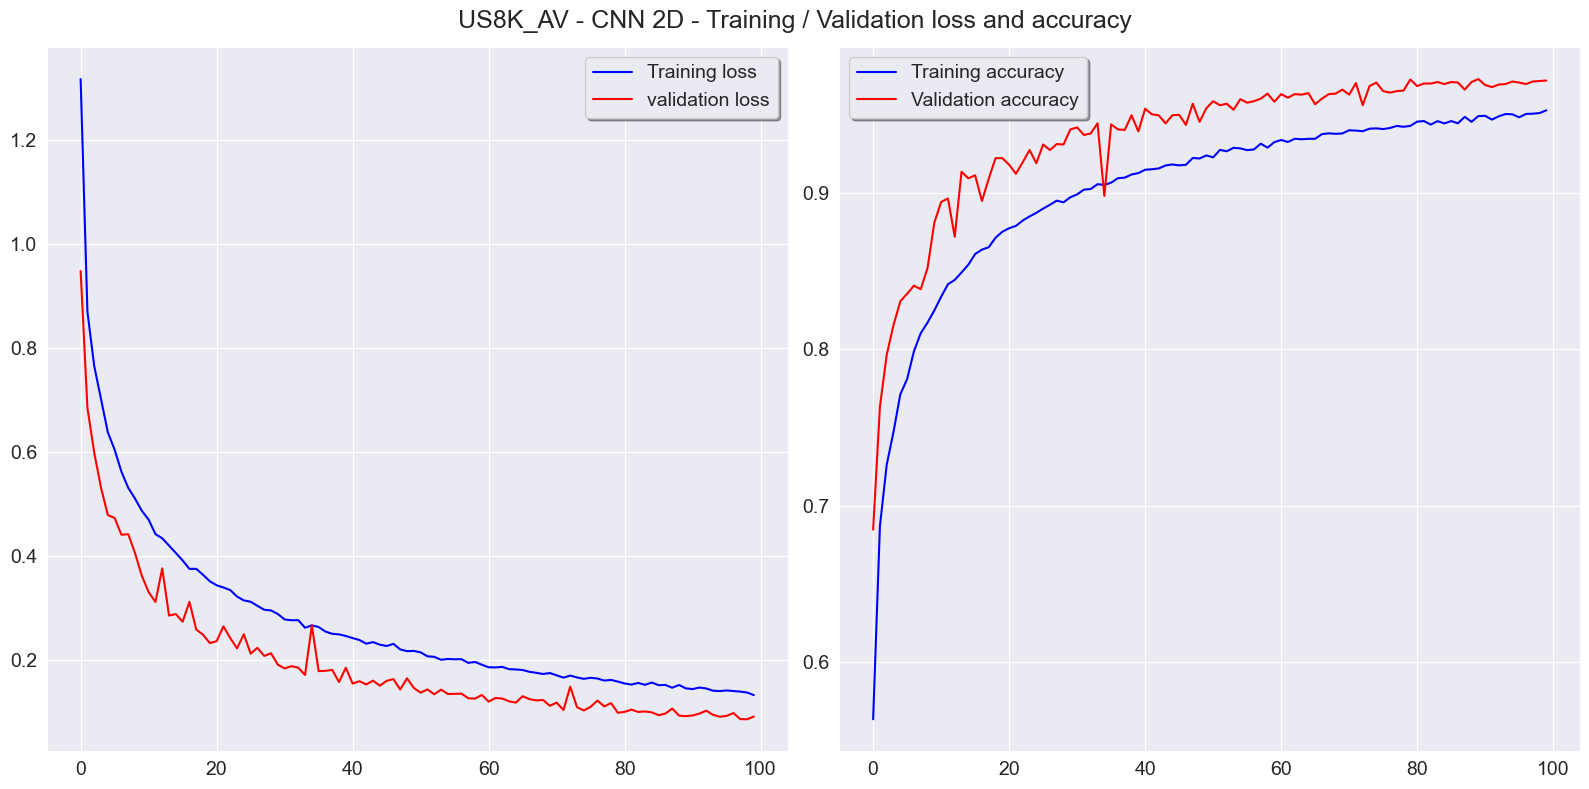

In [37]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle(f'{nom_dataset} - CNN 2D - Training / Validation loss and accuracy', fontsize = 18)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True, fontsize = 14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True, fontsize = 14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [38]:
# save model and architecture to single file (not the best model though)

# Model_CNN_2D.save(os.path.join(path_models, "Model_CNN_2D.hdf5"))
# print("Saved model to disk")

In [39]:
y_pred_CNN_2d = np.argmax(Model_CNN_2D.predict(X_val),axis=1)
y_pred_CNN_2d

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [40]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 4, 4, 4], dtype=int64)

In [41]:
score_CNN_2D[1]

0.8257620930671692

In [42]:
metrics_set_CNN_2D = classification_report(y_test_enc, y_pred_CNN_2d, target_names=nom_classes)
print(metrics_set_CNN_2D)

                  precision    recall  f1-score   support

      background       0.85      0.82      0.83       756
        car_horn       0.80      0.83      0.81       252
children_playing       0.72      0.87      0.79       700
        dog_bark       0.91      0.76      0.83       700
         silence       0.85      0.86      0.85       336
           siren       0.87      0.84      0.85       602

        accuracy                           0.83      3346
       macro avg       0.83      0.83      0.83      3346
    weighted avg       0.83      0.83      0.83      3346



In [43]:
# Load the model with the highest accuracy
# This model will be used in the notebook 10_ESR_data_preparation.ipynb

# Architecture based on Su et al. (2019)
# This model was saved after the training rather than using the best model saved during the training.

Model_CNN_2D_saved = load_model(os.path.join(path_models, 'Model_CNN_2D.hdf5'))
Model_CNN_2D_saved.summary()

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 5, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 5, 64)     

In [44]:
score_CNN_2D_saved = Model_CNN_2D_saved.evaluate(X_val, y_OHEV_val, verbose=1, batch_size = batch_size)
print('Test loss:', score_CNN_2D_saved[0])
print('Test accuracy:', score_CNN_2D_saved[1])

105/105 [==============================] - 0s 3ms/step - loss: 0.8453 - accuracy: 0.8171
Test loss: 0.8452977538108826
Test accuracy: 0.8170950412750244


In [45]:
y_pred_CNN_2D_saved = np.argmax(Model_CNN_2D_saved.predict(X_val),axis=1)
y_pred_CNN_2D_saved

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [46]:
prob = np.round(Model_CNN_2D_saved.predict(X_val)[7],6)
for i in prob:
    print(i)

2.3e-05
0.0
3e-06
0.999896
7.8e-05
0.0


In [47]:
metrics_set_CNN_2D_saved = classification_report(y_test_enc, y_pred_CNN_2D_saved, target_names=nom_classes)
print(metrics_set_CNN_2D_saved)

                  precision    recall  f1-score   support

      background       0.83      0.78      0.81       756
        car_horn       0.86      0.81      0.83       252
children_playing       0.72      0.82      0.77       700
        dog_bark       0.83      0.80      0.81       700
         silence       0.78      0.96      0.86       336
           siren       0.94      0.80      0.87       602

        accuracy                           0.82      3346
       macro avg       0.83      0.83      0.82      3346
    weighted avg       0.82      0.82      0.82      3346



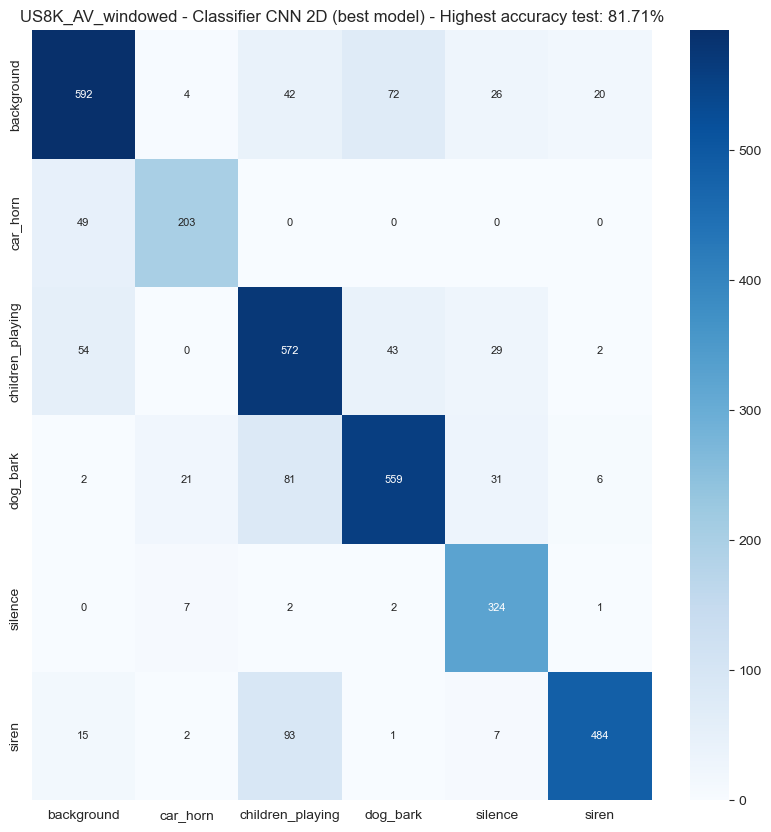

In [48]:
# Simple confusion matrix
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_CNN_2D_saved)
title = nom_dataset + model_surname + ' - Classifier CNN 2D (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_CNN_2D_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [49]:
Model_CNN_2D_saved.layers

In [50]:
for layer in Model_CNN_2D_saved.layers:
    print(layer.get_weights())

[array([[[[-0.37888294,  0.05054501,  0.1170817 ,  0.3940512 ,
           0.05344284, -0.10861577, -0.11463294,  0.0280117 ,
          -0.11823265,  0.18400267, -0.43288743,  0.00533085,
           0.17850879, -0.01922712, -0.04797594, -0.11049446,
          -0.07725666, -0.0285665 , -0.43703052,  0.13192865,
          -0.24487688,  0.04964166,  0.05939614,  0.44480827,
           0.1807613 , -0.48298037, -0.16236646,  0.3758791 ,
           0.0779573 ,  0.05552559, -0.3925779 ,  0.09337605]],

        [[-0.22073056, -0.06062178, -0.02605549,  0.40574905,
           0.01367573,  0.10369164, -0.09564953, -0.01981244,
          -0.01911084,  0.22497283, -0.531744  ,  0.10778108,
           0.044729  ,  0.03654694, -0.09224875,  0.05022788,
          -0.1036434 ,  0.09251997, -0.3825407 ,  0.2779429 ,
          -0.24811147, -0.00838349, -0.07867223,  0.33576834,
           0.02175467, -0.2973779 , -0.12775505,  0.34404057,
           0.09140316,  0.10580628, -0.33452994,  0.17913479]],

 

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [51]:
classifiers = ['Model_CNN_2D_Su', 'Model_CNN_2D_Luz']

In [52]:
# Pipeline to run the classifiers and their metrics

def model_classifiers(classifiers:list, db: pd.DataFrame):
    
    # Clear the session to start a new training
    K.clear_session()
                      
    monitor = EarlyStopping(monitor='val_accuracy', 
                        min_delta = 0.0001, 
                        patience = 20, 
                        verbose = 1, 
                        mode = 'auto', 
                        restore_best_weights = True)
                      
    count       = 1
    verbose     = True
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Val)',
                                                    'F1(Train)',
                                                    'F1(Val)', 
                                                    'Precision(Train)',
                                                    'Precision(Val)', 
                                                    'Recall(Train)',
                                                    'Recall(Val)', 
                                                    'Conf_M',
                                                    'Process_time',                                                     
                                                    'Class_report(Val)'])
                      
    for fold in np.unique(db['Fold']):
        print(f"\nValidation fold: {fold}")

        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]

        X      = DB_TRN['features'].to_numpy()
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL['features'].to_numpy()
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())


        # Stackup and pass all values to float32
        X = np.stack(X)
        X = np.asarray(X).astype(np.float32)

        X_val = np.stack(X_val)
        X_val = np.asarray(X_val).astype(np.float32)

        y_OHEV     = np.asarray(y_OHEV).astype(np.float32)
        y_OHEV_val = np.asarray(y_OHEV_val).astype(np.float32)

        X_train_final, X_test, y_train_final, y_test = train_test_split(X,
                                                                        y_OHEV, 
                                                                        test_size = 0.1, 
                                                                        random_state = 100, 
                                                                        stratify = y_OHEV)
        
        print("\n========================================================================")
        print("Training set\n")

        print(f'X_train.........: {np.shape(X_train_final)} ...type: {type(X_train_final[0][0][0][0])}')
        print(f'y_train_OHEV....: {np.shape(y_train_final)} ............type: {type(y_train_final[0][0])}')

        print("\n========================================================================")
        print("Testing set\n")

        print(f'X_test..........: {np.shape(X_test)} ....type: {type(X_test[0][0][0][0])}')
        print(f'y_test_OHEV.....: {np.shape(y_test)} .............type: {type(y_test[0][0])}')

        print("\n========================================================================")
        print("Validation set\n")

        print(f'X_val...........: {np.shape(X_val)} ....type: {type(X_val[0][0][0][0])}')
        print(f'y_OHEV_val......: {np.shape(y_OHEV_val)} .............type: {type(y_OHEV_val[0][0])}')
        print()

        
        for i in tqdm(range(len(classifiers))):
            
            name         = classifiers[i]
            model_name   = (classifiers[i] + '_' + str(count))
            count        = count + 1
            
            if not os.path.exists(path_models):
                os.makedirs(path_models)

            filepath       = os.path.join(path_models, classifiers[i] + '_weights_0_best' + model_surname + '.hdf5')
            checkpoint     = ModelCheckpoint(filepath, 
                                             monitor = 'val_accuracy', 
                                             verbose = 1, 
                                             save_best_only = True, 
                                             mode = 'max')
            callbacks_list = [checkpoint, monitor]

            if classifiers[i] == 'Model_CNN_2D_Su':
                model = basemodel_Su(classifiers[i])
                model.summary()
                print(model_name)
            
            elif classifiers[i] == 'Model_CNN_2D_Luz':
                model = basemodel_Luz(classifiers[i])
                model.summary()
                print(model_name)
            else:
                pass


            model.fit(X_train_final, 
                      y_train_final,
                      batch_size          = batch_size,
                      epochs              = epochs,
                      verbose             = 1,
                      validation_data     = (X_test, y_test),
                      steps_per_epoch     = int(np.ceil(X_train_final.shape[0] / float(batch_size))),
                      callbacks           = callbacks_list,
                      use_multiprocessing = True)
                      
            # Get the model predictions
            y_train_enc = np.argmax(y_train_final, axis=1)
            y_val_enc   = np.argmax(y_OHEV_val, axis=1)

            y_train_predicted = np.argmax(model.predict(X_train_final), axis=1)

            t_srt             = time.process_time_ns()
            y_val_predicted   = np.argmax(model.predict(X_val), axis=1)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)   
            
            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y_train_enc, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val_enc,  y_val_predicted)

            f1_Score_train = metrics.f1_score(y_train_enc, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            precision_score_train = metrics.precision_score(y_train_enc, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            recall_score_train = metrics.recall_score(y_train_enc, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            class_report_val = classification_report(y_val_enc, y_val_predicted, target_names = nom_classes)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val_enc, y_val_predicted)
            y_val_enc       = []
            y_val_predicted = []

            # Store the name, test accuracy results and model
            models.append((name, accuracy_val, model))
            
            K.clear_session()
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Val)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Val)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Val)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Val)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time],
                                                        'Class_report(Val)': class_report_val})], ignore_index = True)
                   
    return acc_set, models

In [53]:
metrics_set, models_set  = model_classifiers(classifiers, DB_from_pkl)


Validation fold: 1

Training set

X_train.........: (27909, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27909, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3101, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3101, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3346, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3346, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
870/873 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.8539
Epoch 00016: val_accuracy did not improve from 0.89455
873/873 [==============================] - 6s 7ms/step - loss: 0.4073 - accuracy: 0.8539 - val_loss: 0.3428 - val_accuracy: 0.8823
Epoch 17/100
865/873 [============================>.] - ETA: 0s - loss: 0.3964 - accuracy: 0.8598
Epoch 00017: val_accuracy improved from 0.89455 to 0.90293, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.3960 - accuracy: 0.8601 - val_loss: 0.2874 - val_accuracy: 0.9029
Epoch 18/100
871/873 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8648
Epoch 00018: val_accuracy improved from 0.90293 to 0.90326, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

Epoch 40/100
873/873 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9096
Epoch 00040: val_accuracy did not improve from 0.94389
873/873 [==============================] - 6s 7ms/step - loss: 0.2494 - accuracy: 0.9096 - val_loss: 0.1907 - val_accuracy: 0.9342
Epoch 41/100
869/873 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9124
Epoch 00041: val_accuracy did not improve from 0.94389
873/873 [==============================] - 6s 7ms/step - loss: 0.2448 - accuracy: 0.9126 - val_loss: 0.1706 - val_accuracy: 0.9439
Epoch 42/100
870/873 [============================>.] - ETA: 0s - loss: 0.2487 - accuracy: 0.9112
Epoch 00042: val_accuracy did not improve from 0.94389
873/873 [==============================] - 6s 7ms/step - loss: 0.2487 - accuracy: 0.9112 - val_loss: 0.1632 - val_accuracy: 0.9439
Epoch 43/100
872/873 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.9128
Epoch 00043: val_accuracy did not improve from 0.9

Epoch 65/100
871/873 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.9362
Epoch 00065: val_accuracy did not improve from 0.95808
873/873 [==============================] - 6s 7ms/step - loss: 0.1876 - accuracy: 0.9362 - val_loss: 0.1308 - val_accuracy: 0.9536
Epoch 66/100
869/873 [============================>.] - ETA: 0s - loss: 0.1875 - accuracy: 0.9346
Epoch 00066: val_accuracy did not improve from 0.95808
873/873 [==============================] - 6s 7ms/step - loss: 0.1874 - accuracy: 0.9346 - val_loss: 0.1280 - val_accuracy: 0.9526
Epoch 67/100
872/873 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9365
Epoch 00067: val_accuracy improved from 0.95808 to 0.96292, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.1826 - accuracy: 0.9365 - val_loss: 0.1132 - val_accuracy: 0.9629
E

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [10:12<10:12, 612.27s/it]

                  precision    recall  f1-score   support

      background       0.86      0.74      0.80       756
        car_horn       0.84      0.86      0.85       252
children_playing       0.71      0.89      0.79       700
        dog_bark       0.87      0.78      0.82       700
         silence       0.77      0.95      0.85       336
           siren       0.90      0.78      0.83       602

        accuracy                           0.82      3346
       macro avg       0.83      0.83      0.82      3346
    weighted avg       0.83      0.82      0.82      3346

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 15/100
873/873 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9679
Epoch 00015: val_accuracy did not improve from 0.95324
873/873 [==============================] - 15s 18ms/step - loss: 0.0979 - accuracy: 0.9679 - val_loss: 0.1324 - val_accuracy: 0.9500
Epoch 16/100
872/873 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9712
Epoch 00016: val_accuracy did not improve from 0.95324
873/873 [==============================] - 15s 18ms/step - loss: 0.0885 - accuracy: 0.9712 - val_loss: 0.1693 - val_accuracy: 0.9494
Epoch 17/100
871/873 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9715
Epoch 00017: val_accuracy did not improve from 0.95324
873/873 [==============================] - 15s 18ms/step - loss: 0.0841 - accuracy: 0.9715 - val_loss: 0.1405 - val_accuracy: 0.9532
Epoch 18/100
872/873 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9755
Epoch 00018: val_accuracy did not improve fr

Epoch 40/100
870/873 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9942
Epoch 00040: val_accuracy did not improve from 0.97775
873/873 [==============================] - 15s 18ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.1097 - val_accuracy: 0.9761
Epoch 41/100
872/873 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9943
Epoch 00041: val_accuracy did not improve from 0.97775
873/873 [==============================] - 15s 18ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.1748 - val_accuracy: 0.9597
Epoch 42/100
872/873 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9939
Epoch 00042: val_accuracy did not improve from 0.97775
873/873 [==============================] - 15s 18ms/step - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.1250 - val_accuracy: 0.9710
Epoch 43/100
872/873 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9938
Epoch 00043: val_accuracy did not improve fr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [24:12<00:00, 726.29s/it]

                  precision    recall  f1-score   support

      background       0.81      0.82      0.81       756
        car_horn       0.98      0.76      0.86       252
children_playing       0.76      0.87      0.81       700
        dog_bark       0.76      0.87      0.81       700
         silence       0.80      0.58      0.68       336
           siren       0.88      0.76      0.82       602

        accuracy                           0.80      3346
       macro avg       0.83      0.78      0.80      3346
    weighted avg       0.81      0.80      0.80      3346


Validation fold: 10



Training set

X_train.........: (27972, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27972, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3108, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3108, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3276, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3276, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 15/100
871/875 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8480
Epoch 00015: val_accuracy improved from 0.88546 to 0.89189, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.4230 - accuracy: 0.8481 - val_loss: 0.3233 - val_accuracy: 0.8919
Epoch 16/100
869/875 [============================>.] - ETA: 0s - loss: 0.4085 - accuracy: 0.8556
Epoch 00016: val_accuracy did not improve from 0.89189
875/875 [==============================] - 6s 7ms/step - loss: 0.4094 - accuracy: 0.8554 - val_loss: 0.3314 - val_accuracy: 0.8884
Epoch 17/100
870/875 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8552
Epoch 00017: val_accuracy improved from 0.89189 to 0.90154, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

Epoch 39/100
873/875 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.9069
Epoch 00039: val_accuracy improved from 0.93758 to 0.94048, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.2628 - accuracy: 0.9069 - val_loss: 0.1947 - val_accuracy: 0.9405
Epoch 40/100
867/875 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.9091
Epoch 00040: val_accuracy did not improve from 0.94048
875/875 [==============================] - 6s 7ms/step - loss: 0.2582 - accuracy: 0.9092 - val_loss: 0.1859 - val_accuracy: 0.9366
Epoch 41/100
872/875 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.9112
Epoch 00041: val_accuracy did not improve from 0.94048
875/875 [==============================] - 6s 7ms/step - loss: 0.2530 - accuracy: 0.9113 - val_loss: 0.1816 - val_accuracy: 0.9379
E

872/875 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9454
Epoch 00092: val_accuracy did not improve from 0.96364
875/875 [==============================] - 6s 7ms/step - loss: 0.1522 - accuracy: 0.9453 - val_loss: 0.1233 - val_accuracy: 0.9579
Epoch 93/100
872/875 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9460
Epoch 00093: val_accuracy did not improve from 0.96364
875/875 [==============================] - 6s 7ms/step - loss: 0.1523 - accuracy: 0.9461 - val_loss: 0.1146 - val_accuracy: 0.9614
Epoch 94/100
869/875 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9485
Epoch 00094: val_accuracy did not improve from 0.96364
875/875 [==============================] - 6s 7ms/step - loss: 0.1460 - accuracy: 0.9484 - val_loss: 0.1092 - val_accuracy: 0.9633
Epoch 95/100
867/875 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9495
Epoch 00095: val_accuracy improved from 0.96364 to 0.96589, sav

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:48<09:48, 588.92s/it]

                  precision    recall  f1-score   support

      background       0.79      0.93      0.85       721
        car_horn       0.95      0.95      0.95       231
children_playing       0.72      0.89      0.79       700
        dog_bark       0.66      0.75      0.70       700
         silence       0.88      0.60      0.71       343
           siren       0.94      0.48      0.63       581

        accuracy                           0.77      3276
       macro avg       0.82      0.77      0.77      3276
    weighted avg       0.79      0.77      0.76      3276

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 14/100
874/875 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9634
Epoch 00014: val_accuracy did not improve from 0.95045
875/875 [==============================] - 16s 18ms/step - loss: 0.1087 - accuracy: 0.9633 - val_loss: 0.2370 - val_accuracy: 0.9363
Epoch 15/100
873/875 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9638
Epoch 00015: val_accuracy did not improve from 0.95045
875/875 [==============================] - 16s 18ms/step - loss: 0.1100 - accuracy: 0.9639 - val_loss: 0.2357 - val_accuracy: 0.9340
Epoch 16/100
872/875 [============================>.] - ETA: 0s - loss: 0.0906 - accuracy: 0.9692
Epoch 00016: val_accuracy improved from 0.95045 to 0.95206, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
875/875 [==============================] - 16s 18ms/step - loss: 0.0907 - accuracy: 0.9692 - val_loss: 0.1875 - val_accuracy: 0

Epoch 40/100
874/875 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9841
Epoch 00040: val_accuracy did not improve from 0.96911
875/875 [==============================] - 15s 18ms/step - loss: 0.0514 - accuracy: 0.9841 - val_loss: 0.1766 - val_accuracy: 0.9636
Epoch 41/100
872/875 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9908
Epoch 00041: val_accuracy did not improve from 0.96911
875/875 [==============================] - 15s 18ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.2205 - val_accuracy: 0.9530
Epoch 42/100
874/875 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9932
Epoch 00042: val_accuracy improved from 0.96911 to 0.97329, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
875/875 [==============================] - 16s 18ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.1302 - val_accuracy: 0

874/875 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9987
Epoch 00095: val_accuracy did not improve from 0.97780
875/875 [==============================] - 16s 18ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.1769 - val_accuracy: 0.9755
Epoch 96/100
872/875 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9988
Epoch 00096: val_accuracy did not improve from 0.97780
875/875 [==============================] - 16s 18ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.1739 - val_accuracy: 0.9723
Epoch 97/100
873/875 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9990
Epoch 00097: val_accuracy did not improve from 0.97780
875/875 [==============================] - 16s 18ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.1778 - val_accuracy: 0.9749
Epoch 98/100
874/875 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9983
Epoch 00098: val_accuracy did not improve from 0.97780
Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [35:44<00:00, 1072.38s/it]

                  precision    recall  f1-score   support

      background       0.82      0.87      0.84       721
        car_horn       0.91      0.83      0.87       231
children_playing       0.73      0.80      0.76       700
        dog_bark       0.58      0.77      0.66       700
         silence       0.86      0.60      0.70       343
           siren       0.88      0.54      0.67       581

        accuracy                           0.74      3276
       macro avg       0.80      0.74      0.75      3276
    weighted avg       0.77      0.74      0.74      3276


Validation fold: 2



Training set

X_train.........: (27864, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27864, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3097, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3097, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3395, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3395, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 14/100
868/871 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8490
Epoch 00014: val_accuracy improved from 0.88796 to 0.89086, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
871/871 [==============================] - 6s 7ms/step - loss: 0.4212 - accuracy: 0.8491 - val_loss: 0.3174 - val_accuracy: 0.8909
Epoch 15/100
864/871 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8534
Epoch 00015: val_accuracy did not improve from 0.89086
871/871 [==============================] - 6s 7ms/step - loss: 0.4094 - accuracy: 0.8538 - val_loss: 0.3486 - val_accuracy: 0.8802
Epoch 16/100
871/871 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8605
Epoch 00016: val_accuracy did not improve from 0.89086
871/871 [==============================] - 6s 7ms/step - loss: 0.3895 - accuracy: 0.8605 - val_loss: 0.3368 - val_accuracy: 0.8802
E

864/871 [============================>.] - ETA: 0s - loss: 0.1921 - accuracy: 0.9321
Epoch 00061: val_accuracy improved from 0.95641 to 0.95964, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
871/871 [==============================] - 6s 7ms/step - loss: 0.1919 - accuracy: 0.9321 - val_loss: 0.1355 - val_accuracy: 0.9596
Epoch 62/100
870/871 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9304
Epoch 00062: val_accuracy did not improve from 0.95964
871/871 [==============================] - 6s 7ms/step - loss: 0.1936 - accuracy: 0.9304 - val_loss: 0.1464 - val_accuracy: 0.9519
Epoch 63/100
867/871 [============================>.] - ETA: 0s - loss: 0.1900 - accuracy: 0.9332
Epoch 00063: val_accuracy did not improve from 0.95964
871/871 [==============================] - 6s 7ms/step - loss: 0.1898 - accuracy: 0.9333 - val_loss: 0.1327 - val_accuracy: 0.9583
Epoch 64/100
8

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [10:11<10:11, 611.05s/it]

                  precision    recall  f1-score   support

      background       0.86      0.83      0.85       672
        car_horn       0.98      0.59      0.74       294
children_playing       0.67      0.94      0.78       700
        dog_bark       0.89      0.88      0.88       700
         silence       0.92      0.97      0.95       392
           siren       0.94      0.71      0.81       637

        accuracy                           0.84      3395
       macro avg       0.88      0.82      0.83      3395
    weighted avg       0.86      0.84      0.84      3395

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 14/100
869/871 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9618
Epoch 00014: val_accuracy did not improve from 0.95286
871/871 [==============================] - 16s 18ms/step - loss: 0.1122 - accuracy: 0.9619 - val_loss: 0.1698 - val_accuracy: 0.9503
Epoch 15/100
868/871 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9643
Epoch 00015: val_accuracy improved from 0.95286 to 0.95673, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
871/871 [==============================] - 16s 18ms/step - loss: 0.1061 - accuracy: 0.9643 - val_loss: 0.1546 - val_accuracy: 0.9567
Epoch 16/100
868/871 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9696
Epoch 00016: val_accuracy did not improve from 0.95673
871/871 [==============================] - 16s 18ms/step - loss: 0.0953 - accuracy: 0.9696 - val_loss: 0.2155 - val_accuracy: 0

Epoch 41/100
868/871 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9931
Epoch 00041: val_accuracy did not improve from 0.96997
871/871 [==============================] - 15s 18ms/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.1567 - val_accuracy: 0.9690
Epoch 42/100
869/871 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9939
Epoch 00042: val_accuracy improved from 0.96997 to 0.97029, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
871/871 [==============================] - 15s 18ms/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.1670 - val_accuracy: 0.9703
Epoch 43/100
869/871 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9951
Epoch 00043: val_accuracy improved from 0.97029 to 0.97255, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [30:08<00:00, 904.10s/it]

                  precision    recall  f1-score   support

      background       0.78      0.66      0.71       672
        car_horn       0.90      0.49      0.63       294
children_playing       0.65      0.91      0.76       700
        dog_bark       0.74      0.85      0.79       700
         silence       0.91      0.62      0.73       392
           siren       0.78      0.76      0.77       637

        accuracy                           0.75      3395
       macro avg       0.79      0.71      0.73      3395
    weighted avg       0.77      0.75      0.75      3395


Validation fold: 3



Training set

X_train.........: (27543, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27543, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3061, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3061, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3752, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3752, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

861/861 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8581
Epoch 00015: val_accuracy improved from 0.89938 to 0.90428, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
861/861 [==============================] - 6s 7ms/step - loss: 0.3996 - accuracy: 0.8581 - val_loss: 0.3039 - val_accuracy: 0.9043
Epoch 16/100
854/861 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8672
Epoch 00016: val_accuracy did not improve from 0.90428
861/861 [==============================] - 6s 7ms/step - loss: 0.3829 - accuracy: 0.8672 - val_loss: 0.2893 - val_accuracy: 0.9000
Epoch 17/100
854/861 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8665
Epoch 00017: val_accuracy improved from 0.90428 to 0.90918, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf

857/861 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9351
Epoch 00066: val_accuracy did not improve from 0.95851
861/861 [==============================] - 6s 7ms/step - loss: 0.1767 - accuracy: 0.9351 - val_loss: 0.1263 - val_accuracy: 0.9552
Epoch 67/100
861/861 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9384
Epoch 00067: val_accuracy did not improve from 0.95851
861/861 [==============================] - 6s 7ms/step - loss: 0.1718 - accuracy: 0.9384 - val_loss: 0.1310 - val_accuracy: 0.9566
Epoch 68/100
858/861 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9406
Epoch 00068: val_accuracy did not improve from 0.95851
861/861 [==============================] - 6s 7ms/step - loss: 0.1712 - accuracy: 0.9407 - val_loss: 0.1342 - val_accuracy: 0.9526
Epoch 69/100
861/861 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9376
Epoch 00069: val_accuracy improved from 0.95851 to 0.95949, sav

Epoch 92/100
861/861 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9497
Epoch 00092: val_accuracy improved from 0.96537 to 0.96570, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
861/861 [==============================] - 6s 7ms/step - loss: 0.1440 - accuracy: 0.9497 - val_loss: 0.1103 - val_accuracy: 0.9657
Epoch 93/100
854/861 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9516
Epoch 00093: val_accuracy did not improve from 0.96570
861/861 [==============================] - 6s 7ms/step - loss: 0.1373 - accuracy: 0.9517 - val_loss: 0.1042 - val_accuracy: 0.9650
Epoch 94/100
855/861 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9480
Epoch 00094: val_accuracy improved from 0.96570 to 0.96602, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [10:05<10:05, 605.06s/it]

                  precision    recall  f1-score   support

      background       0.72      0.85      0.78       840
        car_horn       0.91      0.98      0.94       301
children_playing       0.76      0.90      0.83       700
        dog_bark       0.88      0.77      0.82       700
         silence       0.96      0.76      0.85       378
           siren       0.93      0.79      0.85       833

        accuracy                           0.83      3752
       macro avg       0.86      0.84      0.85      3752
    weighted avg       0.84      0.83      0.83      3752

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 13/100
860/861 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9619
Epoch 00013: val_accuracy improved from 0.94120 to 0.94642, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
861/861 [==============================] - 15s 18ms/step - loss: 0.1129 - accuracy: 0.9619 - val_loss: 0.1727 - val_accuracy: 0.9464
Epoch 14/100
858/861 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9658
Epoch 00014: val_accuracy improved from 0.94642 to 0.95100, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
861/861 [==============================] - 15s 18ms/step - loss: 0.1033 - accuracy: 0.9658 - val_loss: 0.1700 - val_accuracy: 0.9510
Epoch 15/100
859/861 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9700
Epoch 00015: val_accuracy did not 

Epoch 38/100
861/861 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9937
Epoch 00038: val_accuracy did not improve from 0.96733
861/861 [==============================] - 15s 18ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.2863 - val_accuracy: 0.9451
Epoch 39/100
860/861 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9921
Epoch 00039: val_accuracy did not improve from 0.96733
861/861 [==============================] - 15s 18ms/step - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.2358 - val_accuracy: 0.9503
Epoch 40/100
860/861 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9947
Epoch 00040: val_accuracy did not improve from 0.96733
861/861 [==============================] - 15s 18ms/step - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.1834 - val_accuracy: 0.9660
Epoch 41/100
858/861 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9937
Epoch 00041: val_accuracy did not improve fr

Epoch 64/100
859/861 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9973
Epoch 00064: val_accuracy did not improve from 0.97386
861/861 [==============================] - 15s 18ms/step - loss: 0.0081 - accuracy: 0.9973 - val_loss: 0.2247 - val_accuracy: 0.9686
Epoch 65/100
858/861 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00065: val_accuracy did not improve from 0.97386
861/861 [==============================] - 15s 18ms/step - loss: 0.0050 - accuracy: 0.9982 - val_loss: 0.2093 - val_accuracy: 0.9706
Epoch 66/100
858/861 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9977
Epoch 00066: val_accuracy did not improve from 0.97386
861/861 [==============================] - 15s 18ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.2147 - val_accuracy: 0.9673
Epoch 67/100
858/861 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.9975
Epoch 00067: val_accuracy did not improve fr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [31:19<00:00, 939.86s/it]

                  precision    recall  f1-score   support

      background       0.77      0.84      0.81       840
        car_horn       0.95      0.93      0.94       301
children_playing       0.73      0.84      0.78       700
        dog_bark       0.75      0.87      0.81       700
         silence       0.94      0.50      0.66       378
           siren       0.98      0.85      0.91       833

        accuracy                           0.82      3752
       macro avg       0.85      0.81      0.82      3752
    weighted avg       0.84      0.82      0.82      3752


Validation fold: 4



Training set

X_train.........: (27146, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27146, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3017, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3017, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (4193, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (4193, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

845/849 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8550
Epoch 00015: val_accuracy did not improve from 0.88929
849/849 [==============================] - 6s 7ms/step - loss: 0.4066 - accuracy: 0.8550 - val_loss: 0.3295 - val_accuracy: 0.8866
Epoch 16/100
841/849 [============================>.] - ETA: 0s - loss: 0.3921 - accuracy: 0.8588
Epoch 00016: val_accuracy did not improve from 0.88929
849/849 [==============================] - 6s 7ms/step - loss: 0.3923 - accuracy: 0.8588 - val_loss: 0.3328 - val_accuracy: 0.8840
Epoch 17/100
844/849 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.8617
Epoch 00017: val_accuracy did not improve from 0.88929
849/849 [==============================] - 6s 7ms/step - loss: 0.3848 - accuracy: 0.8617 - val_loss: 0.4591 - val_accuracy: 0.8565
Epoch 18/100
844/849 [============================>.] - ETA: 0s - loss: 0.3738 - accuracy: 0.8656
Epoch 00018: val_accuracy did not improve from 0.88929
849/849 

Epoch 65/100
845/849 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9349
Epoch 00065: val_accuracy did not improve from 0.95625
849/849 [==============================] - 6s 7ms/step - loss: 0.1840 - accuracy: 0.9349 - val_loss: 0.1244 - val_accuracy: 0.9539
Epoch 66/100
845/849 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9368
Epoch 00066: val_accuracy improved from 0.95625 to 0.95691, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
849/849 [==============================] - 6s 7ms/step - loss: 0.1813 - accuracy: 0.9368 - val_loss: 0.1293 - val_accuracy: 0.9569
Epoch 67/100
848/849 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9360
Epoch 00067: val_accuracy improved from 0.95691 to 0.96023, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

Epoch 91/100
848/849 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9473
Epoch 00091: val_accuracy did not improve from 0.96652
849/849 [==============================] - 6s 7ms/step - loss: 0.1502 - accuracy: 0.9473 - val_loss: 0.1023 - val_accuracy: 0.9655
Epoch 92/100
844/849 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9481
Epoch 00092: val_accuracy did not improve from 0.96652
849/849 [==============================] - 6s 7ms/step - loss: 0.1465 - accuracy: 0.9481 - val_loss: 0.1085 - val_accuracy: 0.9632
Epoch 93/100
844/849 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9473
Epoch 00093: val_accuracy did not improve from 0.96652
849/849 [==============================] - 6s 7ms/step - loss: 0.1471 - accuracy: 0.9473 - val_loss: 0.1112 - val_accuracy: 0.9635
Epoch 94/100
842/849 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9491
Epoch 00094: val_accuracy did not improve from 0.9

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:28<09:28, 568.30s/it]

                  precision    recall  f1-score   support

      background       0.73      0.68      0.70       798
        car_horn       0.86      0.74      0.80       413
children_playing       0.57      0.80      0.66       700
        dog_bark       0.73      0.88      0.80       700
         silence       0.92      0.67      0.78       420
           siren       0.89      0.73      0.80      1162

        accuracy                           0.75      4193
       macro avg       0.78      0.75      0.76      4193
    weighted avg       0.78      0.75      0.75      4193

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 40/100
846/849 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9945
Epoch 00040: val_accuracy did not improve from 0.97713
849/849 [==============================] - 15s 18ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.1591 - val_accuracy: 0.9698
Epoch 41/100
849/849 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9939
Epoch 00041: val_accuracy did not improve from 0.97713
849/849 [==============================] - 15s 18ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.1711 - val_accuracy: 0.9695
Epoch 42/100
847/849 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9938
Epoch 00042: val_accuracy did not improve from 0.97713
849/849 [==============================] - 15s 18ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.1594 - val_accuracy: 0.9672
Epoch 43/100
846/849 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9945
Epoch 00043: val_accuracy did not improve fr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [27:04<00:00, 812.39s/it]

                  precision    recall  f1-score   support

      background       0.68      0.75      0.72       798
        car_horn       0.91      0.68      0.78       413
children_playing       0.66      0.69      0.67       700
        dog_bark       0.65      0.87      0.74       700
         silence       0.93      0.58      0.71       420
           siren       0.91      0.86      0.88      1162

        accuracy                           0.76      4193
       macro avg       0.79      0.74      0.75      4193
    weighted avg       0.79      0.76      0.77      4193


Validation fold: 5



Training set

X_train.........: (27587, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27587, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3066, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3066, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3703, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3703, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
855/863 [============================>.] - ETA: 0s - loss: 0.3984 - accuracy: 0.8601
Epoch 00016: val_accuracy did not improve from 0.89889
863/863 [==============================] - 6s 7ms/step - loss: 0.3978 - accuracy: 0.8603 - val_loss: 0.3186 - val_accuracy: 0.8927
Epoch 17/100
863/863 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8642
Epoch 00017: val_accuracy improved from 0.89889 to 0.90313, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
863/863 [==============================] - 6s 7ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.2940 - val_accuracy: 0.9031
Epoch 18/100
855/863 [============================>.] - ETA: 0s - loss: 0.3698 - accuracy: 0.8700
Epoch 00018: val_accuracy improved from 0.90313 to 0.91487, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

862/863 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9376
Epoch 00067: val_accuracy did not improve from 0.96184
863/863 [==============================] - 6s 7ms/step - loss: 0.1778 - accuracy: 0.9376 - val_loss: 0.1131 - val_accuracy: 0.9596
Epoch 68/100
858/863 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9376
Epoch 00068: val_accuracy did not improve from 0.96184
863/863 [==============================] - 6s 7ms/step - loss: 0.1720 - accuracy: 0.9376 - val_loss: 0.1249 - val_accuracy: 0.9566
Epoch 69/100
862/863 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9374
Epoch 00069: val_accuracy did not improve from 0.96184
863/863 [==============================] - 6s 7ms/step - loss: 0.1726 - accuracy: 0.9373 - val_loss: 0.1191 - val_accuracy: 0.9586
Epoch 70/100
861/863 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9383
Epoch 00070: val_accuracy did not improve from 0.96184
863/863 

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:38<09:38, 578.38s/it]

                  precision    recall  f1-score   support

      background       0.77      0.90      0.83       693
        car_horn       0.96      0.84      0.90       686
children_playing       0.77      0.77      0.77       700
        dog_bark       0.63      0.79      0.70       700
         silence       0.90      0.66      0.76       427
           siren       0.92      0.76      0.83       497

        accuracy                           0.80      3703
       macro avg       0.83      0.79      0.80      3703
    weighted avg       0.81      0.80      0.80      3703

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 15/100
861/863 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9686
Epoch 00015: val_accuracy did not improve from 0.96119
863/863 [==============================] - 15s 18ms/step - loss: 0.0983 - accuracy: 0.9686 - val_loss: 0.2365 - val_accuracy: 0.9354
Epoch 16/100
861/863 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9604
Epoch 00016: val_accuracy did not improve from 0.96119
863/863 [==============================] - 15s 18ms/step - loss: 0.1200 - accuracy: 0.9604 - val_loss: 0.1682 - val_accuracy: 0.9416
Epoch 17/100
861/863 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9734
Epoch 00017: val_accuracy did not improve from 0.96119
863/863 [==============================] - 15s 18ms/step - loss: 0.0823 - accuracy: 0.9734 - val_loss: 0.5417 - val_accuracy: 0.8702
Epoch 18/100
861/863 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9745
Epoch 00018: val_accuracy did not improve fr

Epoch 69/100
861/863 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9981
Epoch 00069: val_accuracy did not improve from 0.97717
863/863 [==============================] - 15s 18ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.1668 - val_accuracy: 0.9726
Epoch 70/100
861/863 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9974
Epoch 00070: val_accuracy did not improve from 0.97717
863/863 [==============================] - 15s 18ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.1765 - val_accuracy: 0.9716
Epoch 71/100
861/863 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9979
Epoch 00071: val_accuracy did not improve from 0.97717
863/863 [==============================] - 15s 18ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.1597 - val_accuracy: 0.9759
Epoch 72/100
860/863 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9983
Epoch 00072: val_accuracy improved from 0.97

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [33:07<00:00, 993.72s/it]

                  precision    recall  f1-score   support

      background       0.70      0.86      0.77       693
        car_horn       0.98      0.82      0.89       686
children_playing       0.81      0.75      0.78       700
        dog_bark       0.62      0.81      0.70       700
         silence       0.91      0.66      0.77       427
           siren       0.94      0.77      0.85       497

        accuracy                           0.79      3703
       macro avg       0.83      0.78      0.79      3703
    weighted avg       0.81      0.79      0.79      3703


Validation fold: 6



Training set

X_train.........: (28022, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (28022, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3114, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3114, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3220, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3220, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
875/876 [============================>.] - ETA: 0s - loss: 0.4169 - accuracy: 0.8520
Epoch 00016: val_accuracy improved from 0.88696 to 0.89852, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
876/876 [==============================] - 6s 7ms/step - loss: 0.4168 - accuracy: 0.8520 - val_loss: 0.2993 - val_accuracy: 0.8985
Epoch 17/100
874/876 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8589
Epoch 00017: val_accuracy did not improve from 0.89852
876/876 [==============================] - 6s 7ms/step - loss: 0.3937 - accuracy: 0.8590 - val_loss: 0.3276 - val_accuracy: 0.8793
Epoch 18/100
876/876 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8630
Epoch 00018: val_accuracy improved from 0.89852 to 0.90430, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

Epoch 41/100
871/876 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.9131
Epoch 00041: val_accuracy did not improve from 0.94284
876/876 [==============================] - 6s 7ms/step - loss: 0.2482 - accuracy: 0.9131 - val_loss: 0.1854 - val_accuracy: 0.9342
Epoch 42/100
873/876 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.9136
Epoch 00042: val_accuracy did not improve from 0.94284
876/876 [==============================] - 6s 7ms/step - loss: 0.2496 - accuracy: 0.9135 - val_loss: 0.1951 - val_accuracy: 0.9313
Epoch 43/100
875/876 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9155
Epoch 00043: val_accuracy did not improve from 0.94284
876/876 [==============================] - 6s 7ms/step - loss: 0.2419 - accuracy: 0.9155 - val_loss: 0.1788 - val_accuracy: 0.9403
Epoch 44/100
871/876 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9163
Epoch 00044: val_accuracy did not improve from 0.9

872/876 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9479
Epoch 00093: val_accuracy did not improve from 0.96757
876/876 [==============================] - 6s 7ms/step - loss: 0.1458 - accuracy: 0.9479 - val_loss: 0.1000 - val_accuracy: 0.9650
Epoch 94/100
874/876 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9479
Epoch 00094: val_accuracy improved from 0.96757 to 0.96917, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
876/876 [==============================] - 6s 7ms/step - loss: 0.1456 - accuracy: 0.9480 - val_loss: 0.0954 - val_accuracy: 0.9692
Epoch 95/100
868/876 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9496
Epoch 00095: val_accuracy did not improve from 0.96917
876/876 [==============================] - 6s 7ms/step - loss: 0.1425 - accuracy: 0.9496 - val_loss: 0.1001 - val_accuracy: 0.9666
Epoch 96/100
8

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:49<09:49, 589.15s/it]

                  precision    recall  f1-score   support

      background       0.66      0.85      0.74       686
        car_horn       0.87      0.78      0.82       196
children_playing       0.85      0.83      0.84       700
        dog_bark       0.91      0.79      0.84       700
         silence       0.87      0.95      0.91       420
           siren       0.83      0.66      0.74       518

        accuracy                           0.81      3220
       macro avg       0.83      0.81      0.82      3220
    weighted avg       0.82      0.81      0.81      3220

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

875/876 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9929
Epoch 00039: val_accuracy did not improve from 0.97206
876/876 [==============================] - 15s 18ms/step - loss: 0.0225 - accuracy: 0.9929 - val_loss: 0.1685 - val_accuracy: 0.9663
Epoch 40/100
874/876 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9942
Epoch 00040: val_accuracy did not improve from 0.97206
876/876 [==============================] - 16s 18ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.1520 - val_accuracy: 0.9698
Epoch 41/100
874/876 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9938
Epoch 00041: val_accuracy did not improve from 0.97206
876/876 [==============================] - 16s 18ms/step - loss: 0.0171 - accuracy: 0.9938 - val_loss: 0.1914 - val_accuracy: 0.9669
Epoch 42/100
873/876 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9923
Epoch 00042: val_accuracy did not improve from 0.97206
87

875/876 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9988
Epoch 00094: val_accuracy did not improve from 0.97688
876/876 [==============================] - 16s 18ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.2122 - val_accuracy: 0.9724
Epoch 95/100
874/876 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 00095: val_accuracy did not improve from 0.97688
876/876 [==============================] - 16s 18ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.1983 - val_accuracy: 0.9746
Epoch 96/100
873/876 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9990
Epoch 00096: val_accuracy did not improve from 0.97688
Restoring model weights from the end of the best epoch.
876/876 [==============================] - 15s 18ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.1994 - val_accuracy: 0.9733
Epoch 00096: early stopping


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [34:44<00:00, 1042.02s/it]

                  precision    recall  f1-score   support

      background       0.73      0.76      0.74       686
        car_horn       0.85      0.85      0.85       196
children_playing       0.84      0.87      0.85       700
        dog_bark       0.76      0.85      0.80       700
         silence       0.89      0.58      0.70       420
           siren       0.76      0.76      0.76       518

        accuracy                           0.79      3220
       macro avg       0.80      0.78      0.78      3220
    weighted avg       0.79      0.79      0.78      3220


Validation fold: 7



Training set

X_train.........: (27990, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27990, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3111, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3111, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3255, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3255, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 17/100
872/875 [============================>.] - ETA: 0s - loss: 0.3970 - accuracy: 0.8547
Epoch 00017: val_accuracy improved from 0.89328 to 0.89425, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.3967 - accuracy: 0.8547 - val_loss: 0.3077 - val_accuracy: 0.8942
Epoch 18/100
872/875 [============================>.] - ETA: 0s - loss: 0.3828 - accuracy: 0.8629
Epoch 00018: val_accuracy did not improve from 0.89425
875/875 [==============================] - 6s 7ms/step - loss: 0.3828 - accuracy: 0.8629 - val_loss: 0.3274 - val_accuracy: 0.8914
Epoch 19/100
873/875 [============================>.] - ETA: 0s - loss: 0.3691 - accuracy: 0.8706
Epoch 00019: val_accuracy did not improve from 0.89425
875/875 [==============================] - 6s 7ms/step - loss: 0.3691 - accuracy: 0.8706 - val_loss: 0.6559 - val_accuracy: 0.7779
E

Epoch 41/100
869/875 [============================>.] - ETA: 0s - loss: 0.2512 - accuracy: 0.9108
Epoch 00041: val_accuracy did not improve from 0.93282
875/875 [==============================] - 6s 7ms/step - loss: 0.2509 - accuracy: 0.9109 - val_loss: 0.2103 - val_accuracy: 0.9290
Epoch 42/100
867/875 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9135
Epoch 00042: val_accuracy did not improve from 0.93282
875/875 [==============================] - 6s 7ms/step - loss: 0.2381 - accuracy: 0.9133 - val_loss: 0.2070 - val_accuracy: 0.9315
Epoch 43/100
873/875 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9132
Epoch 00043: val_accuracy improved from 0.93282 to 0.93668, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.2398 - accuracy: 0.9133 - val_loss: 0.1911 - val_accuracy: 0.9367
E

Epoch 66/100
868/875 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9324
Epoch 00066: val_accuracy did not improve from 0.95243
875/875 [==============================] - 6s 7ms/step - loss: 0.1900 - accuracy: 0.9325 - val_loss: 0.1551 - val_accuracy: 0.9482
Epoch 67/100
875/875 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9322
Epoch 00067: val_accuracy did not improve from 0.95243
875/875 [==============================] - 6s 7ms/step - loss: 0.1865 - accuracy: 0.9322 - val_loss: 0.1493 - val_accuracy: 0.9499
Epoch 68/100
867/875 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9339
Epoch 00068: val_accuracy did not improve from 0.95243
875/875 [==============================] - 6s 7ms/step - loss: 0.1844 - accuracy: 0.9338 - val_loss: 0.1470 - val_accuracy: 0.9495
Epoch 69/100
870/875 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9339
Epoch 00069: val_accuracy did not improve from 0.9

Epoch 93/100
871/875 [============================>.] - ETA: 0s - loss: 0.1489 - accuracy: 0.9461
Epoch 00093: val_accuracy did not improve from 0.95918
875/875 [==============================] - 6s 7ms/step - loss: 0.1490 - accuracy: 0.9461 - val_loss: 0.1266 - val_accuracy: 0.9560
Epoch 94/100
867/875 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9469
Epoch 00094: val_accuracy improved from 0.95918 to 0.96046, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.1466 - accuracy: 0.9470 - val_loss: 0.1197 - val_accuracy: 0.9605
Epoch 95/100
869/875 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9464
Epoch 00095: val_accuracy did not improve from 0.96046
875/875 [==============================] - 6s 7ms/step - loss: 0.1494 - accuracy: 0.9464 - val_loss: 0.1182 - val_accuracy: 0.9592
E

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:49<09:49, 589.90s/it]

                  precision    recall  f1-score   support

      background       0.80      0.79      0.79       700
        car_horn       0.68      0.90      0.77       196
children_playing       0.77      0.83      0.80       700
        dog_bark       0.83      0.79      0.81       700
         silence       0.90      0.89      0.89       420
           siren       0.84      0.75      0.79       539

        accuracy                           0.81      3255
       macro avg       0.80      0.82      0.81      3255
    weighted avg       0.81      0.81      0.81      3255

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 40/100
874/875 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9943
Epoch 00040: val_accuracy did not improve from 0.97203
875/875 [==============================] - 15s 18ms/step - loss: 0.0163 - accuracy: 0.9943 - val_loss: 0.1435 - val_accuracy: 0.9704
Epoch 41/100
873/875 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9951
Epoch 00041: val_accuracy improved from 0.97203 to 0.97428, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
875/875 [==============================] - 15s 18ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.1460 - val_accuracy: 0.9743
Epoch 42/100
874/875 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9948
Epoch 00042: val_accuracy did not improve from 0.97428
875/875 [==============================] - 15s 18ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.1328 - val_accuracy: 0

Epoch 68/100
872/875 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9972
Epoch 00068: val_accuracy did not improve from 0.97461
875/875 [==============================] - 15s 18ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.1492 - val_accuracy: 0.9746
Epoch 69/100
873/875 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979
Epoch 00069: val_accuracy did not improve from 0.97461
875/875 [==============================] - 15s 18ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.1548 - val_accuracy: 0.9746
Epoch 70/100
874/875 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9979
Epoch 00070: val_accuracy did not improve from 0.97461
875/875 [==============================] - 15s 18ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.1648 - val_accuracy: 0.9740
Epoch 71/100
872/875 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9981
Epoch 00071: val_accuracy did not improve fr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [33:55<00:00, 1017.67s/it]

                  precision    recall  f1-score   support

      background       0.70      0.79      0.74       700
        car_horn       0.94      0.80      0.87       196
children_playing       0.76      0.86      0.81       700
        dog_bark       0.69      0.84      0.76       700
         silence       0.91      0.64      0.75       420
           siren       0.88      0.59      0.71       539

        accuracy                           0.76      3255
       macro avg       0.81      0.75      0.77      3255
    weighted avg       0.78      0.76      0.76      3255


Validation fold: 8



Training set

X_train.........: (28142, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (28142, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3127, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3127, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3087, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3087, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
875/880 [============================>.] - ETA: 0s - loss: 0.3967 - accuracy: 0.8584
Epoch 00016: val_accuracy did not improve from 0.89191
880/880 [==============================] - 6s 7ms/step - loss: 0.3963 - accuracy: 0.8585 - val_loss: 0.3982 - val_accuracy: 0.8638
Epoch 17/100
879/880 [============================>.] - ETA: 0s - loss: 0.3817 - accuracy: 0.8637
Epoch 00017: val_accuracy improved from 0.89191 to 0.90054, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
880/880 [==============================] - 6s 7ms/step - loss: 0.3818 - accuracy: 0.8637 - val_loss: 0.2913 - val_accuracy: 0.9005
Epoch 18/100
876/880 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8652
Epoch 00018: val_accuracy did not improve from 0.90054
880/880 [==============================] - 6s 7ms/step - loss: 0.3758 - accuracy: 0.8649 - val_loss: 0.3003 - val_accuracy: 0.8887
E

Epoch 41/100
876/880 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9161
Epoch 00041: val_accuracy improved from 0.94595 to 0.94691, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
880/880 [==============================] - 6s 7ms/step - loss: 0.2361 - accuracy: 0.9161 - val_loss: 0.1563 - val_accuracy: 0.9469
Epoch 42/100
874/880 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9157
Epoch 00042: val_accuracy did not improve from 0.94691
880/880 [==============================] - 6s 7ms/step - loss: 0.2367 - accuracy: 0.9158 - val_loss: 0.1842 - val_accuracy: 0.9332
Epoch 43/100
872/880 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9162
Epoch 00043: val_accuracy did not improve from 0.94691
880/880 [==============================] - 6s 7ms/step - loss: 0.2366 - accuracy: 0.9161 - val_loss: 0.1819 - val_accuracy: 0.9412
E

Epoch 67/100
879/880 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9370
Epoch 00067: val_accuracy did not improve from 0.96226
880/880 [==============================] - 6s 7ms/step - loss: 0.1768 - accuracy: 0.9370 - val_loss: 0.1133 - val_accuracy: 0.9619
Epoch 68/100
877/880 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9354
Epoch 00068: val_accuracy did not improve from 0.96226
880/880 [==============================] - 6s 7ms/step - loss: 0.1806 - accuracy: 0.9354 - val_loss: 0.1204 - val_accuracy: 0.9578
Epoch 69/100
872/880 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9369
Epoch 00069: val_accuracy did not improve from 0.96226
880/880 [==============================] - 6s 7ms/step - loss: 0.1755 - accuracy: 0.9369 - val_loss: 0.1150 - val_accuracy: 0.9591
Epoch 70/100
872/880 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9365
Epoch 00070: val_accuracy did not improve from 0.9

Epoch 94/100
873/880 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9494
Epoch 00094: val_accuracy did not improve from 0.96898
880/880 [==============================] - 6s 7ms/step - loss: 0.1444 - accuracy: 0.9494 - val_loss: 0.1176 - val_accuracy: 0.9597
Epoch 95/100
872/880 [============================>.] - ETA: 0s - loss: 0.1424 - accuracy: 0.9483
Epoch 00095: val_accuracy did not improve from 0.96898
880/880 [==============================] - 6s 7ms/step - loss: 0.1427 - accuracy: 0.9483 - val_loss: 0.1041 - val_accuracy: 0.9648
Epoch 96/100
878/880 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9503
Epoch 00096: val_accuracy improved from 0.96898 to 0.97154, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
880/880 [==============================] - 6s 7ms/step - loss: 0.1377 - accuracy: 0.9504 - val_loss: 0.0845 - val_accuracy: 0.9715
E

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:51<09:51, 591.95s/it]

                  precision    recall  f1-score   support

      background       0.68      0.80      0.74       560
        car_horn       0.79      0.86      0.82       210
children_playing       0.79      0.67      0.72       700
        dog_bark       0.88      0.79      0.83       700
         silence       0.80      0.98      0.88       357
           siren       0.80      0.77      0.79       560

        accuracy                           0.79      3087
       macro avg       0.79      0.81      0.80      3087
    weighted avg       0.79      0.79      0.79      3087

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 14/100
879/880 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9601
Epoch 00014: val_accuracy did not improve from 0.94883
880/880 [==============================] - 16s 18ms/step - loss: 0.1141 - accuracy: 0.9602 - val_loss: 0.1924 - val_accuracy: 0.9386
Epoch 15/100
879/880 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9669
Epoch 00015: val_accuracy improved from 0.94883 to 0.96194, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
880/880 [==============================] - 16s 18ms/step - loss: 0.0997 - accuracy: 0.9670 - val_loss: 0.1310 - val_accuracy: 0.9619
Epoch 16/100
879/880 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9691
Epoch 00016: val_accuracy did not improve from 0.96194
880/880 [==============================] - 16s 18ms/step - loss: 0.0916 - accuracy: 0.9691 - val_loss: 0.1522 - val_accuracy: 0

Epoch 40/100
878/880 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9927
Epoch 00040: val_accuracy did not improve from 0.97570
880/880 [==============================] - 16s 18ms/step - loss: 0.0204 - accuracy: 0.9927 - val_loss: 0.2000 - val_accuracy: 0.9619
Epoch 41/100
877/880 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9931
Epoch 00041: val_accuracy did not improve from 0.97570
880/880 [==============================] - 16s 18ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.1113 - val_accuracy: 0.9719
Epoch 42/100
877/880 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9930
Epoch 00042: val_accuracy did not improve from 0.97570
880/880 [==============================] - 16s 18ms/step - loss: 0.0210 - accuracy: 0.9930 - val_loss: 0.1354 - val_accuracy: 0.9738
Epoch 43/100
879/880 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9930
Epoch 00043: val_accuracy did not improve fr

Epoch 68/100
878/880 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9970
Epoch 00068: val_accuracy did not improve from 0.97793
880/880 [==============================] - 16s 18ms/step - loss: 0.0082 - accuracy: 0.9970 - val_loss: 0.1118 - val_accuracy: 0.9770
Epoch 69/100
878/880 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9971
Epoch 00069: val_accuracy did not improve from 0.97793
880/880 [==============================] - 16s 18ms/step - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.0972 - val_accuracy: 0.9773
Epoch 70/100
878/880 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9972
Epoch 00070: val_accuracy did not improve from 0.97793
880/880 [==============================] - 16s 18ms/step - loss: 0.0074 - accuracy: 0.9972 - val_loss: 0.1285 - val_accuracy: 0.9776
Epoch 71/100
877/880 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984
Epoch 00071: val_accuracy improved from 0.97

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [34:05<00:00, 1022.59s/it]

                  precision    recall  f1-score   support

      background       0.65      0.79      0.71       560
        car_horn       0.87      0.92      0.89       210
children_playing       0.83      0.67      0.74       700
        dog_bark       0.76      0.81      0.79       700
         silence       0.90      0.90      0.90       357
           siren       0.85      0.79      0.82       560

        accuracy                           0.79      3087
       macro avg       0.81      0.81      0.81      3087
    weighted avg       0.80      0.79      0.79      3087


Validation fold: 9



Training set

X_train.........: (28104, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (28104, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3123, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3123, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3129, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3129, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
874/879 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8550
Epoch 00016: val_accuracy improved from 0.89657 to 0.89850, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
879/879 [==============================] - 6s 7ms/step - loss: 0.4060 - accuracy: 0.8554 - val_loss: 0.2890 - val_accuracy: 0.8985
Epoch 17/100
875/879 [============================>.] - ETA: 0s - loss: 0.3915 - accuracy: 0.8629
Epoch 00017: val_accuracy did not improve from 0.89850
879/879 [==============================] - 6s 7ms/step - loss: 0.3913 - accuracy: 0.8630 - val_loss: 0.2934 - val_accuracy: 0.8947
Epoch 18/100
874/879 [============================>.] - ETA: 0s - loss: 0.3840 - accuracy: 0.8621
Epoch 00018: val_accuracy improved from 0.89850 to 0.90458, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

878/879 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9374
Epoch 00064: val_accuracy improved from 0.95773 to 0.95933, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
879/879 [==============================] - 6s 7ms/step - loss: 0.1774 - accuracy: 0.9373 - val_loss: 0.1229 - val_accuracy: 0.9593
Epoch 65/100
874/879 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9348
Epoch 00065: val_accuracy did not improve from 0.95933
879/879 [==============================] - 6s 7ms/step - loss: 0.1844 - accuracy: 0.9348 - val_loss: 0.1358 - val_accuracy: 0.9558
Epoch 66/100
876/879 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9337
Epoch 00066: val_accuracy did not improve from 0.95933
879/879 [==============================] - 6s 7ms/step - loss: 0.1884 - accuracy: 0.9336 - val_loss: 0.1221 - val_accuracy: 0.9593
Epoch 67/100
8

Epoch 89/100
873/879 [============================>.] - ETA: 0s - loss: 0.1508 - accuracy: 0.9471
Epoch 00089: val_accuracy did not improve from 0.96958
879/879 [==============================] - 6s 7ms/step - loss: 0.1506 - accuracy: 0.9471 - val_loss: 0.1222 - val_accuracy: 0.9587
Epoch 90/100
874/879 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9481
Epoch 00090: val_accuracy did not improve from 0.96958
879/879 [==============================] - 6s 7ms/step - loss: 0.1476 - accuracy: 0.9479 - val_loss: 0.0988 - val_accuracy: 0.9664
Epoch 91/100
878/879 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9493
Epoch 00091: val_accuracy did not improve from 0.96958
879/879 [==============================] - 6s 7ms/step - loss: 0.1454 - accuracy: 0.9493 - val_loss: 0.1045 - val_accuracy: 0.9680
Epoch 92/100
874/879 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9480
Epoch 00092: val_accuracy did not improve from 0.9

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [09:51<09:51, 591.59s/it]

                  precision    recall  f1-score   support

      background       0.82      0.89      0.85       574
        car_horn       0.94      0.98      0.96       224
children_playing       0.82      0.84      0.83       700
        dog_bark       0.84      0.72      0.78       700
         silence       0.80      0.84      0.82       357
           siren       0.94      0.95      0.95       574

        accuracy                           0.85      3129
       macro avg       0.86      0.87      0.86      3129
    weighted avg       0.85      0.85      0.85      3129

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

876/879 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9942
Epoch 00040: val_accuracy did not improve from 0.97406
879/879 [==============================] - 15s 18ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.1345 - val_accuracy: 0.9718
Epoch 41/100
877/879 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9933
Epoch 00041: val_accuracy did not improve from 0.97406
879/879 [==============================] - 16s 18ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.1523 - val_accuracy: 0.9680
Epoch 42/100
877/879 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9938
Epoch 00042: val_accuracy did not improve from 0.97406
879/879 [==============================] - 16s 18ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.1611 - val_accuracy: 0.9651
Epoch 43/100
878/879 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9920
Epoch 00043: val_accuracy did not improve from 0.97406
87

Epoch 68/100
876/879 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985
Epoch 00068: val_accuracy did not improve from 0.97919
879/879 [==============================] - 16s 18ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.2014 - val_accuracy: 0.9670
Epoch 69/100
878/879 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9987
Epoch 00069: val_accuracy did not improve from 0.97919
879/879 [==============================] - 15s 18ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.2032 - val_accuracy: 0.9657
Epoch 70/100
878/879 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9987
Epoch 00070: val_accuracy did not improve from 0.97919
879/879 [==============================] - 16s 18ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.1429 - val_accuracy: 0.9763
Epoch 71/100
876/879 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9968
Epoch 00071: val_accuracy did not improve fr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [33:47<00:00, 1013.59s/it]

                  precision    recall  f1-score   support

      background       0.77      0.85      0.81       574
        car_horn       0.91      0.89      0.90       224
children_playing       0.83      0.74      0.79       700
        dog_bark       0.73      0.73      0.73       700
         silence       0.82      0.73      0.78       357
           siren       0.84      0.92      0.88       574

        accuracy                           0.80      3129
       macro avg       0.82      0.81      0.81      3129
    weighted avg       0.80      0.80      0.80      3129



In [54]:
metrics_set

,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,Model_CNN_2D_Su,1,0.985381,0.817095,0.985389,0.817246,...,0.827627,0.985381,0.817095,"[[560, 13, 69, 50, 25, 39], [35, 217, 0, 0, 0, 0], [26, 0, 621, 19, 33, 1], [2, 21, 84, 549, 31, 13], [0, 7, 6, 3, 3...",187.500,precision recall f1-score support\n\n background 0.86 0.74 0.80 7...
1,Model_CNN_2D_Luz,1,0.998925,0.803646,0.998925,0.802335,...,0.811661,0.998925,0.803646,"[[621, 0, 38, 49, 4, 44], [51, 192, 0, 9, 0, 0], [39, 1, 608, 34, 15, 3], [9, 2, 41, 612, 25, 11], [28, 0, 7, 101, 1...",890.625,precision recall f1-score support\n\n background 0.81 0.82 0.81 7...
2,Model_CNN_2D_Su,10,0.986165,0.769536,0.986162,0.761414,...,0.793677,0.986165,0.769536,"[[673, 6, 28, 8, 0, 6], [8, 219, 4, 0, 0, 0], [40, 0, 620, 27, 11, 2], [34, 0, 117, 526, 14, 9], [15, 0, 1, 121, 206...",375.000,precision recall f1-score support\n\n background 0.79 0.93 0.85 7...
3,Model_CNN_2D_Luz,10,0.999964,0.744811,0.999964,0.743897,...,0.769847,0.999964,0.744811,"[[630, 2, 49, 17, 0, 23], [26, 192, 11, 2, 0, 0], [34, 0, 559, 71, 24, 12], [50, 7, 83, 542, 10, 8], [0, 0, 1, 137, ...",656.250,precision recall f1-score support\n\n background 0.82 0.87 0.84 7...
4,Model_CNN_2D_Su,2,0.985824,0.836524,0.985831,0.836138,...,0.859385,0.985824,0.836524,"[[561, 0, 86, 14, 0, 11], [21, 174, 73, 6, 20, 0], [27, 0, 657, 5, 0, 11], [7, 0, 63, 615, 10, 5], [0, 0, 2, 8, 380,...",546.875,precision recall f1-score support\n\n background 0.86 0.83 0.85 6...
5,Model_CNN_2D_Luz,2,0.999785,0.749337,0.999785,0.745177,...,0.769819,0.999785,0.749337,"[[444, 5, 86, 10, 6, 121], [35, 144, 114, 1, 0, 0], [41, 1, 637, 11, 0, 10], [35, 0, 55, 595, 10, 5], [1, 0, 9, 137,...",578.125,precision recall f1-score support\n\n background 0.78 0.66 0.71 6...
6,Model_CNN_2D_Su,3,0.989507,0.831023,0.989501,0.832311,...,0.844401,0.989507,0.831023,"[[711, 25, 83, 9, 0, 12], [7, 294, 0, 0, 0, 0], [33, 0, 629, 27, 2, 9], [74, 1, 57, 542, 11, 15], [5, 2, 47, 23, 288...",328.125,precision recall f1-score support\n\n background 0.72 0.85 0.78 8...
7,Model_CNN_2D_Luz,3,0.999601,0.822495,0.999601,0.821008,...,0.838805,0.999601,0.822495,"[[709, 14, 91, 17, 5, 4], [21, 280, 0, 0, 0, 0], [32, 0, 589, 75, 1, 3], [41, 0, 43, 608, 6, 2], [11, 1, 82, 92, 190...",765.625,precision recall f1-score support\n\n background 0.77 0.84 0.81 8...
8,Model_CNN_2D_Su,4,0.987696,0.751014,0.987696,0.754703,...,0.776819,0.987696,0.751014,"[[541, 43, 127, 27, 3, 57], [89, 307, 4, 12, 0, 1], [67, 5, 558, 68, 0, 2], [3, 2, 41, 617, 21, 16], [14, 0, 49, 41,...",265.625,precision recall f1-score support\n\n background 0.73 0.68 0.70 7...
9,Model_CNN_2D_Luz,4,0.999668,0.764369,0.999669,0.765904,...,0.785716,0.999668,0.764369,"[[602, 20, 74, 42, 1, 59], [117, 280, 6, 0, 0, 10], [102, 0, 480, 111, 1, 6], [16, 0, 47, 607, 15, 15], [17, 7, 29, ...",890.625,precision recall f1-score support\n\n background 0.68 0.75 0.72 7...


In [55]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Val)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,3,Model_CNN_2D_Luz,10,0.999964,0.744811,0.999964,...,0.769847,0.999964,0.744811,"[[630, 2, 49, 17, 0, 23], [26, 192, 11, 2, 0, 0], [34, 0, 559, 71, 24, 12], [50, 7, 83, 542, 10, 8], [0, 0, 1, 137, ...",656.250,precision recall f1-score support\n\n background 0.82 0.87 0.84 7...
1,5,Model_CNN_2D_Luz,2,0.999785,0.749337,0.999785,...,0.769819,0.999785,0.749337,"[[444, 5, 86, 10, 6, 121], [35, 144, 114, 1, 0, 0], [41, 1, 637, 11, 0, 10], [35, 0, 55, 595, 10, 5], [1, 0, 9, 137,...",578.125,precision recall f1-score support\n\n background 0.78 0.66 0.71 6...
2,15,Model_CNN_2D_Luz,7,1.000000,0.762519,1.000000,...,0.781334,1.000000,0.762519,"[[551, 1, 75, 61, 5, 7], [14, 157, 15, 9, 1, 0], [51, 1, 601, 27, 0, 20], [14, 1, 67, 585, 19, 14], [3, 0, 12, 134, ...",484.375,precision recall f1-score support\n\n background 0.70 0.79 0.74 7...
3,9,Model_CNN_2D_Luz,4,0.999668,0.764369,0.999669,...,0.785716,0.999668,0.764369,"[[602, 20, 74, 42, 1, 59], [117, 280, 6, 0, 0, 10], [102, 0, 480, 111, 1, 6], [16, 0, 47, 607, 15, 15], [17, 7, 29, ...",890.625,precision recall f1-score support\n\n background 0.68 0.75 0.72 7...
4,13,Model_CNN_2D_Luz,6,0.999893,0.785404,0.999893,...,0.791090,0.999893,0.785404,"[[522, 11, 53, 34, 2, 64], [27, 167, 1, 1, 0, 0], [51, 9, 609, 22, 5, 4], [29, 2, 40, 593, 18, 18], [0, 0, 7, 128, 2...",609.375,precision recall f1-score support\n\n background 0.73 0.76 0.74 6...
5,11,Model_CNN_2D_Luz,5,0.999964,0.787200,0.999964,...,0.814625,0.999964,0.787200,"[[593, 5, 20, 61, 8, 6], [115, 560, 5, 2, 0, 4], [93, 3, 528, 65, 6, 5], [28, 0, 81, 567, 15, 9], [0, 0, 1, 143, 283...",703.125,precision recall f1-score support\n\n background 0.70 0.86 0.77 6...
6,17,Model_CNN_2D_Luz,8,1.000000,0.788468,1.000000,...,0.797019,1.000000,0.788468,"[[444, 4, 39, 57, 2, 14], [5, 193, 12, 0, 0, 0], [153, 6, 470, 50, 5, 16], [31, 19, 41, 567, 1, 41], [0, 0, 1, 31, 3...",546.875,precision recall f1-score support\n\n background 0.65 0.79 0.71 5...
7,19,Model_CNN_2D_Luz,9,0.999964,0.802493,0.999964,...,0.803731,0.999964,0.802493,"[[490, 8, 34, 17, 0, 25], [17, 199, 1, 7, 0, 0], [41, 3, 521, 86, 10, 39], [77, 7, 40, 511, 35, 30], [3, 1, 26, 58, ...",562.500,precision recall f1-score support\n\n background 0.77 0.85 0.81 5...
8,1,Model_CNN_2D_Luz,1,0.998925,0.803646,0.998925,...,0.811661,0.998925,0.803646,"[[621, 0, 38, 49, 4, 44], [51, 192, 0, 9, 0, 0], [39, 1, 608, 34, 15, 3], [9, 2, 41, 612, 25, 11], [28, 0, 7, 101, 1...",890.625,precision recall f1-score support\n\n background 0.81 0.82 0.81 7...
9,7,Model_CNN_2D_Luz,3,0.999601,0.822495,0.999601,...,0.838805,0.999601,0.822495,"[[709, 14, 91, 17, 5, 4], [21, 280, 0, 0, 0, 0], [32, 0, 589, 75, 1, 3], [41, 0, 43, 608, 6, 2], [11, 1, 82, 92, 190...",765.625,precision recall f1-score support\n\n background 0.77 0.84 0.81 8...


In [56]:
metrics_set[['Model', 'Accuracy(Val)']].style.background_gradient(cmap = cmap_cm)

,Model,Accuracy(Val)
0,Model_CNN_2D_Luz,0.744811
1,Model_CNN_2D_Luz,0.749337
2,Model_CNN_2D_Luz,0.762519
3,Model_CNN_2D_Luz,0.764369
4,Model_CNN_2D_Luz,0.785404
5,Model_CNN_2D_Luz,0.787200
6,Model_CNN_2D_Luz,0.788468
7,Model_CNN_2D_Luz,0.802493
8,Model_CNN_2D_Luz,0.803646
9,Model_CNN_2D_Luz,0.822495


In [57]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Val)'].max()
highest_accuracy

Model
Model_CNN_2D_Luz    0.822495
Model_CNN_2D_Su     0.852669
Name: Accuracy(Val), dtype: float64

In [58]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [59]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

Model...: Model_CNN_2D_Su


,index,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,9.0000,0.9867,0.8063,0.9867,0.8061,0.9869,0.8200,0.9867,0.8063,307.8125
std,6.0553,0.0025,0.0311,0.0025,0.0314,0.0024,0.0272,0.0025,0.0311,103.1329
min,0.0000,0.9820,0.7510,0.9820,0.7547,0.9822,0.7768,0.9820,0.7510,187.5000
25%,4.5000,0.9855,0.7898,0.9855,0.7896,0.9859,0.7987,0.9855,0.7898,230.4688
50%,9.0000,0.9869,0.8110,0.9869,0.8116,0.9871,0.8194,0.9869,0.8110,304.6875
75%,13.5000,0.9888,0.8275,0.9888,0.8285,0.9889,0.8402,0.9888,0.8275,328.1250
max,18.0000,0.9895,0.8527,0.9895,0.8513,0.9896,0.8594,0.9895,0.8527,546.8750


Model...: Model_CNN_2D_Luz


,index,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,10.0000,0.9998,0.7811,0.9998,0.7805,0.9998,0.7964,0.9998,0.7811,668.7500
std,6.0553,0.0003,0.0253,0.0003,0.0257,0.0003,0.0216,0.0003,0.0253,141.8351
min,1.0000,0.9989,0.7448,0.9989,0.7439,0.9989,0.7698,0.9989,0.7448,484.3750
25%,5.5000,0.9997,0.7630,0.9997,0.7623,0.9997,0.7824,0.9997,0.7630,566.4062
50%,10.0000,0.9999,0.7863,0.9999,0.7862,0.9999,0.7941,0.9999,0.7863,632.8125
75%,14.5000,1.0000,0.7990,1.0000,0.7991,1.0000,0.8097,1.0000,0.7990,750.0000
max,19.0000,1.0000,0.8225,1.0000,0.8210,1.0000,0.8388,1.0000,0.8225,890.6250


In [60]:
metrics_set_no_cm = metrics_set.drop(['Conf_M', 'Class_report(Val)'], axis=1)
metrics_set_no_cm

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
0,3,Model_CNN_2D_Luz,10,0.999964,0.744811,0.999964,0.743897,0.999964,0.769847,0.999964,0.744811,656.250
1,5,Model_CNN_2D_Luz,2,0.999785,0.749337,0.999785,0.745177,0.999785,0.769819,0.999785,0.749337,578.125
2,15,Model_CNN_2D_Luz,7,1.000000,0.762519,1.000000,0.761144,1.000000,0.781334,1.000000,0.762519,484.375
3,9,Model_CNN_2D_Luz,4,0.999668,0.764369,0.999669,0.765904,0.999669,0.785716,0.999668,0.764369,890.625
4,13,Model_CNN_2D_Luz,6,0.999893,0.785404,0.999893,0.783299,0.999893,0.791090,0.999893,0.785404,609.375
5,11,Model_CNN_2D_Luz,5,0.999964,0.787200,0.999964,0.792074,0.999964,0.814625,0.999964,0.787200,703.125
6,17,Model_CNN_2D_Luz,8,1.000000,0.788468,1.000000,0.789008,1.000000,0.797019,1.000000,0.788468,546.875
7,19,Model_CNN_2D_Luz,9,0.999964,0.802493,0.999964,0.801502,0.999964,0.803731,0.999964,0.802493,562.500
8,1,Model_CNN_2D_Luz,1,0.998925,0.803646,0.998925,0.802335,0.998928,0.811661,0.998925,0.803646,890.625
9,7,Model_CNN_2D_Luz,3,0.999601,0.822495,0.999601,0.821008,0.999601,0.838805,0.999601,0.822495,765.625


In [61]:
metrics_set_name       = nom_dataset + '_metrics_set_CNN_2D' +  model_surname + '.pkl'
metrics_set_name_no_cm = nom_dataset + '_metrics_set_CNN_2D' +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

US8K_AV_metrics_set_CNN_2D_windowed.pkl
US8K_AV_metrics_set_CNN_2D_windowed_no_cm.csv


In [62]:
# Writes de results to a PKL and CSV file

with open(os.path.join(path_models, metrics_set_name), 'wb') as file:
    pickle.dump(metrics_set, file)
    
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [63]:
metrics_set_from_pkl = pd.read_pickle(os.path.join(path_models, metrics_set_name))
metrics_set_from_pkl

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,3,Model_CNN_2D_Luz,10,0.999964,0.744811,0.999964,...,0.769847,0.999964,0.744811,"[[630, 2, 49, 17, 0, 23], [26, 192, 11, 2, 0, 0], [34, 0, 559, 71, 24, 12], [50, 7, 83, 542, 10, 8], [0, 0, 1, 137, ...",656.250,precision recall f1-score support\n\n background 0.82 0.87 0.84 7...
1,5,Model_CNN_2D_Luz,2,0.999785,0.749337,0.999785,...,0.769819,0.999785,0.749337,"[[444, 5, 86, 10, 6, 121], [35, 144, 114, 1, 0, 0], [41, 1, 637, 11, 0, 10], [35, 0, 55, 595, 10, 5], [1, 0, 9, 137,...",578.125,precision recall f1-score support\n\n background 0.78 0.66 0.71 6...
2,15,Model_CNN_2D_Luz,7,1.000000,0.762519,1.000000,...,0.781334,1.000000,0.762519,"[[551, 1, 75, 61, 5, 7], [14, 157, 15, 9, 1, 0], [51, 1, 601, 27, 0, 20], [14, 1, 67, 585, 19, 14], [3, 0, 12, 134, ...",484.375,precision recall f1-score support\n\n background 0.70 0.79 0.74 7...
3,9,Model_CNN_2D_Luz,4,0.999668,0.764369,0.999669,...,0.785716,0.999668,0.764369,"[[602, 20, 74, 42, 1, 59], [117, 280, 6, 0, 0, 10], [102, 0, 480, 111, 1, 6], [16, 0, 47, 607, 15, 15], [17, 7, 29, ...",890.625,precision recall f1-score support\n\n background 0.68 0.75 0.72 7...
4,13,Model_CNN_2D_Luz,6,0.999893,0.785404,0.999893,...,0.791090,0.999893,0.785404,"[[522, 11, 53, 34, 2, 64], [27, 167, 1, 1, 0, 0], [51, 9, 609, 22, 5, 4], [29, 2, 40, 593, 18, 18], [0, 0, 7, 128, 2...",609.375,precision recall f1-score support\n\n background 0.73 0.76 0.74 6...
5,11,Model_CNN_2D_Luz,5,0.999964,0.787200,0.999964,...,0.814625,0.999964,0.787200,"[[593, 5, 20, 61, 8, 6], [115, 560, 5, 2, 0, 4], [93, 3, 528, 65, 6, 5], [28, 0, 81, 567, 15, 9], [0, 0, 1, 143, 283...",703.125,precision recall f1-score support\n\n background 0.70 0.86 0.77 6...
6,17,Model_CNN_2D_Luz,8,1.000000,0.788468,1.000000,...,0.797019,1.000000,0.788468,"[[444, 4, 39, 57, 2, 14], [5, 193, 12, 0, 0, 0], [153, 6, 470, 50, 5, 16], [31, 19, 41, 567, 1, 41], [0, 0, 1, 31, 3...",546.875,precision recall f1-score support\n\n background 0.65 0.79 0.71 5...
7,19,Model_CNN_2D_Luz,9,0.999964,0.802493,0.999964,...,0.803731,0.999964,0.802493,"[[490, 8, 34, 17, 0, 25], [17, 199, 1, 7, 0, 0], [41, 3, 521, 86, 10, 39], [77, 7, 40, 511, 35, 30], [3, 1, 26, 58, ...",562.500,precision recall f1-score support\n\n background 0.77 0.85 0.81 5...
8,1,Model_CNN_2D_Luz,1,0.998925,0.803646,0.998925,...,0.811661,0.998925,0.803646,"[[621, 0, 38, 49, 4, 44], [51, 192, 0, 9, 0, 0], [39, 1, 608, 34, 15, 3], [9, 2, 41, 612, 25, 11], [28, 0, 7, 101, 1...",890.625,precision recall f1-score support\n\n background 0.81 0.82 0.81 7...
9,7,Model_CNN_2D_Luz,3,0.999601,0.822495,0.999601,...,0.838805,0.999601,0.822495,"[[709, 14, 91, 17, 5, 4], [21, 280, 0, 0, 0, 0], [32, 0, 589, 75, 1, 3], [41, 0, 43, 608, 6, 2], [11, 1, 82, 92, 190...",765.625,precision recall f1-score support\n\n background 0.77 0.84 0.81 8...


In [64]:
idx = metrics_set.groupby('Model')['Accuracy(Val)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Val)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'Model_CNN_2D_Luz': {'Accuracy(Val)': 0.8224946695095949,
  'Conf_M': array([[709,  14,  91,  17,   5,   4],
         [ 21, 280,   0,   0,   0,   0],
         [ 32,   0, 589,  75,   1,   3],
         [ 41,   0,  43, 608,   6,   2],
         [ 11,   1,  82,  92, 190,   2],
         [101,   1,   5,  16,   0, 710]], dtype=int64)},
 'Model_CNN_2D_Su': {'Accuracy(Val)': 0.8526685842122084,
  'Conf_M': array([[511,   4,  41,   4,   3,  11],
         [  4, 220,   0,   0,   0,   0],
         [ 20,   0, 589,  55,  24,  12],
         [ 91,  11,  51, 504,  40,   3],
         [  0,   0,  28,  23, 299,   7],
         [  0,   0,   9,  12,   8, 545]], dtype=int64)}}

In [65]:
conf_matrices_dict['Model_CNN_2D_Su']['Conf_M']

array([[511,   4,  41,   4,   3,  11],
       [  4, 220,   0,   0,   0,   0],
       [ 20,   0, 589,  55,  24,  12],
       [ 91,  11,  51, 504,  40,   3],
       [  0,   0,  28,  23, 299,   7],
       [  0,   0,   9,  12,   8, 545]], dtype=int64)

In [66]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Val)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
Model_CNN_2D_Luz
0.8224946695095949
[[709  14  91  17   5   4]
 [ 21 280   0   0   0   0]
 [ 32   0 589  75   1   3]
 [ 41   0  43 608   6   2]
 [ 11   1  82  92 190   2]
 [101   1   5  16   0 710]]
2
Model_CNN_2D_Su
0.8526685842122084
[[511   4  41   4   3  11]
 [  4 220   0   0   0   0]
 [ 20   0 589  55  24  12]
 [ 91  11  51 504  40   3]
 [  0   0  28  23 299   7]
 [  0   0   9  12   8 545]]


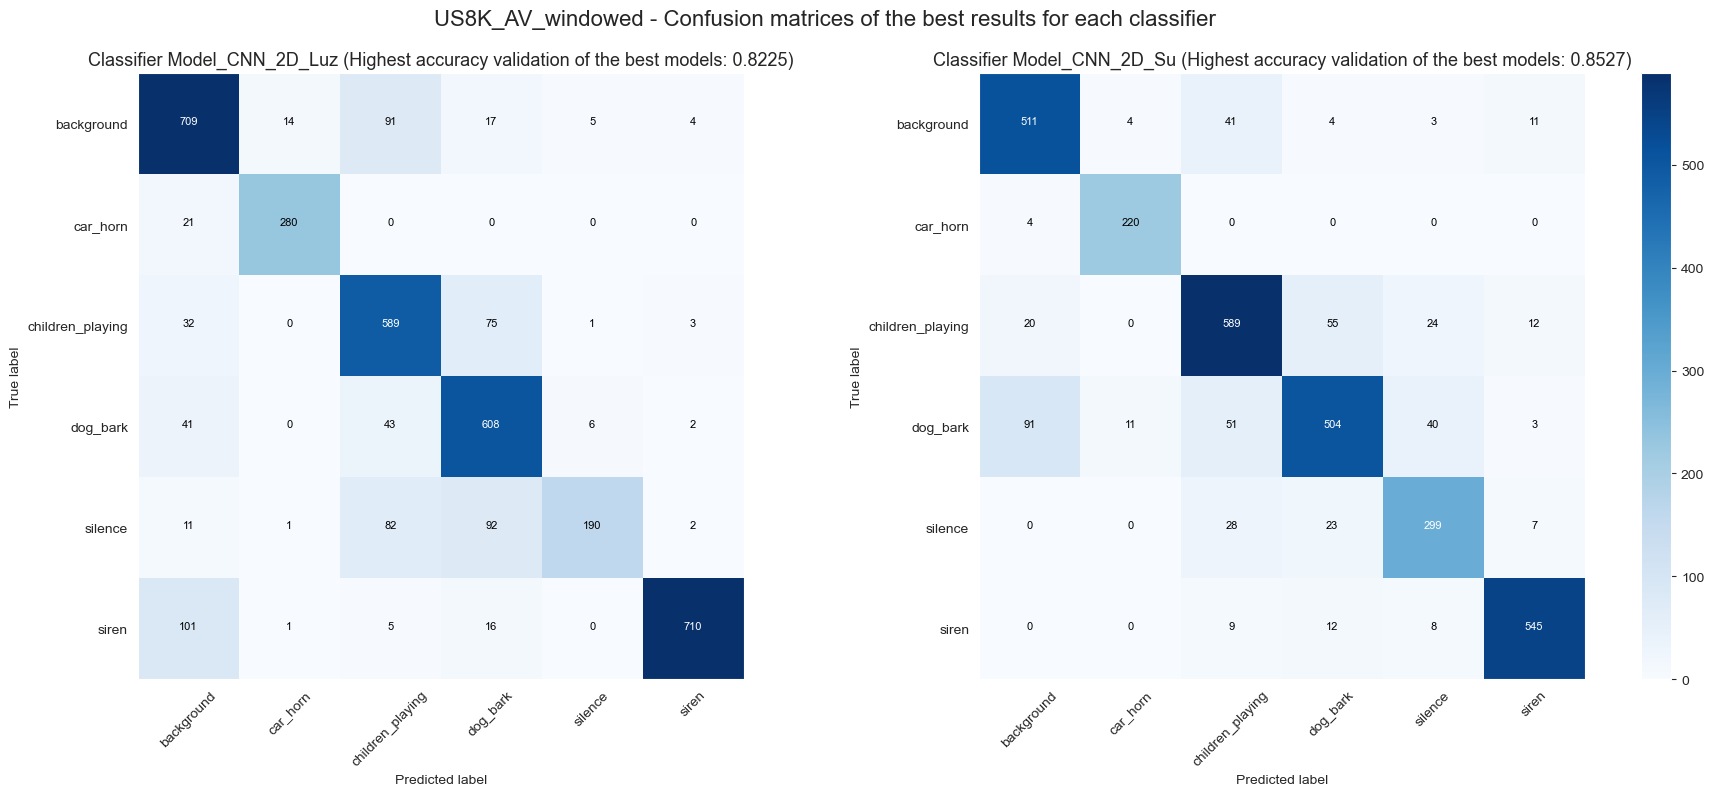

In [67]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(20,8))
plt.suptitle(nom_dataset + model_surname + ' - Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.99)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = 'Classifier '+ i + ' (Highest accuracy validation of the best models: ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Val)'])) +')'
    plt.subplot(1,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)

plt.savefig(os.path.join(path_pic, picture_name))
plt.tight_layout()

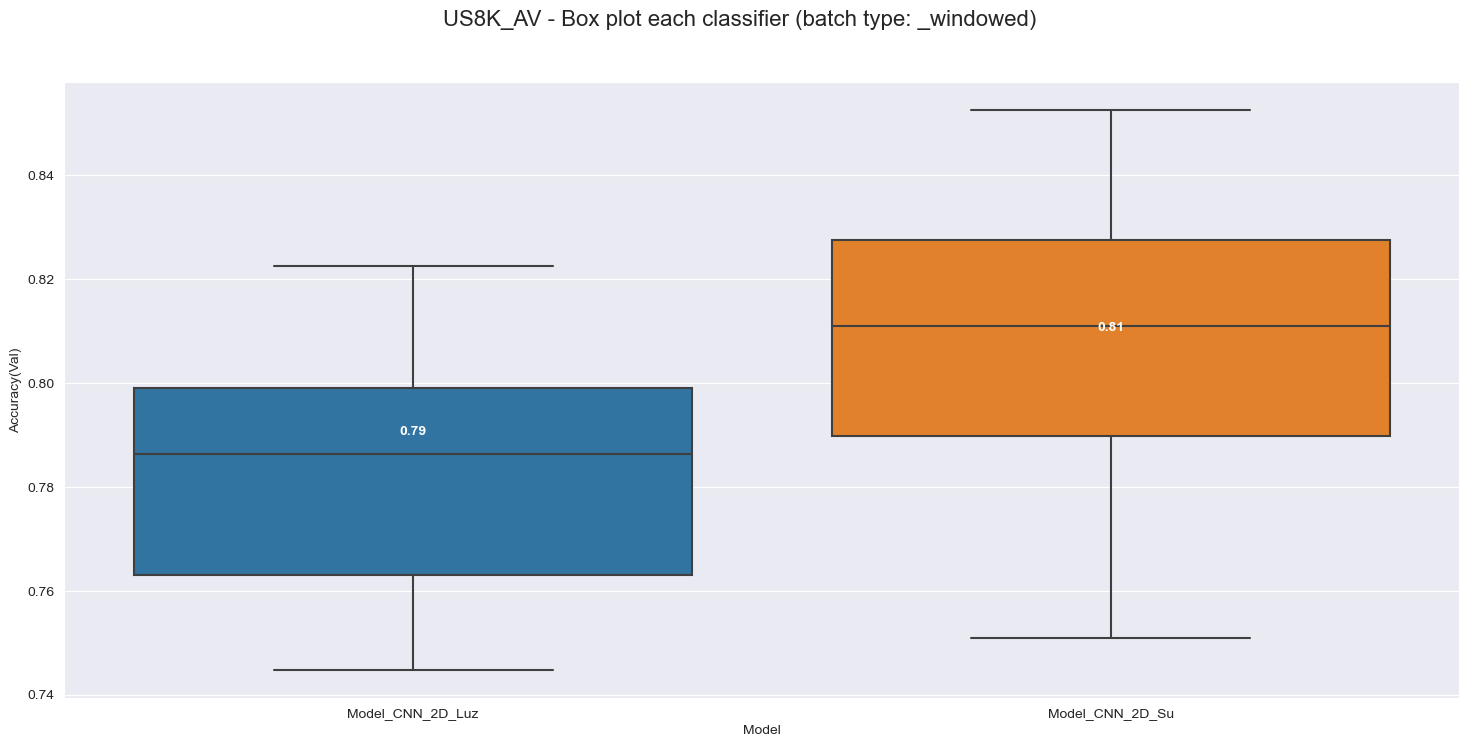

In [68]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Val)", showfliers = True)

medians = list(metrics_set.groupby(['Model'])['Accuracy(Val)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Val)'].median()*0.0001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

## Results ESC-10 - Compiled in Excel

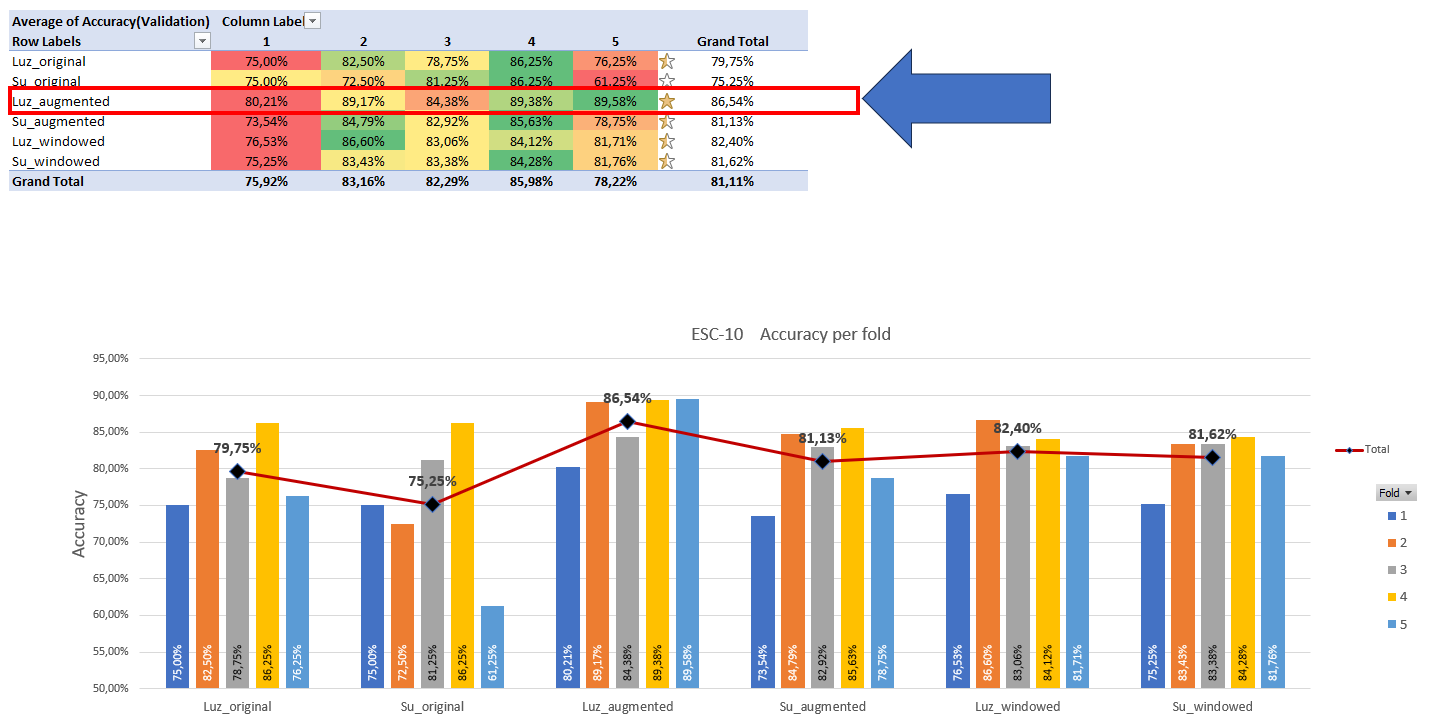

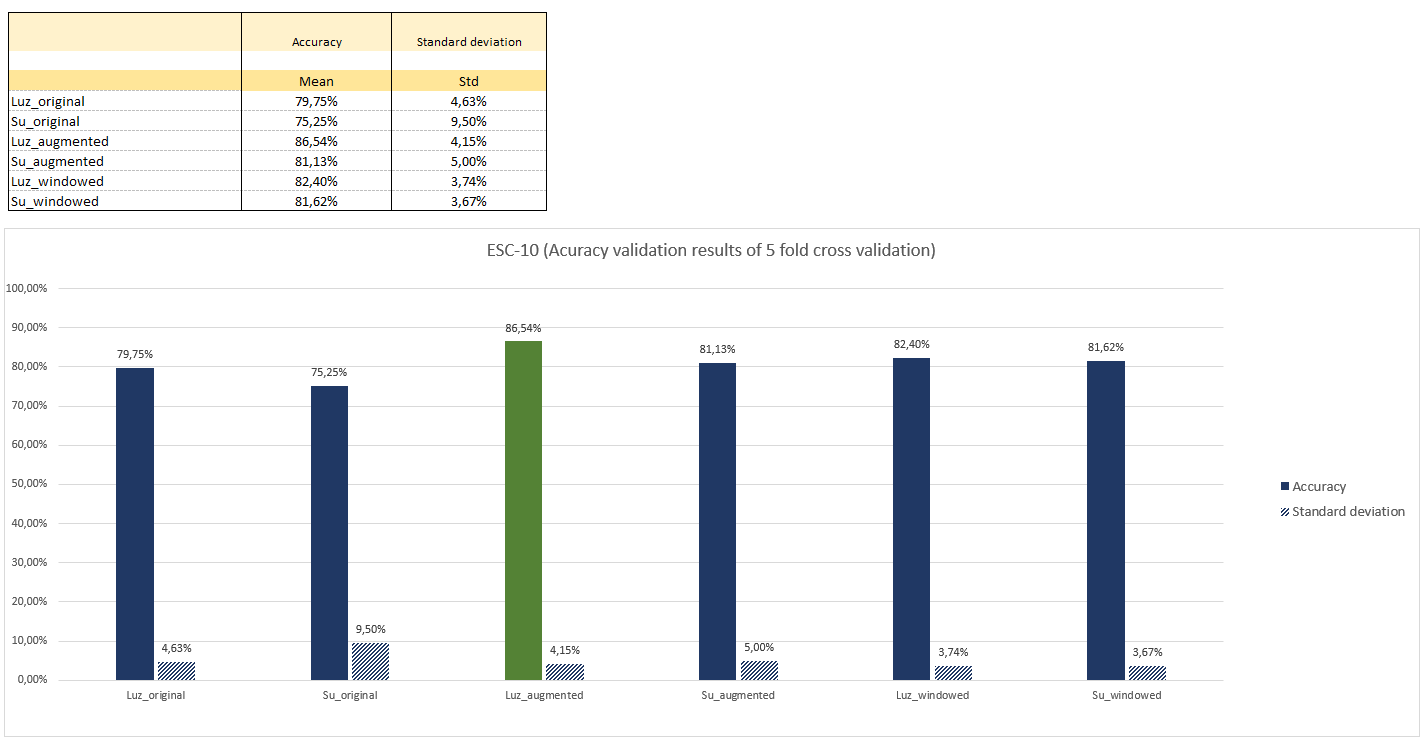

## Results BDLib2 - Compiled in Excel

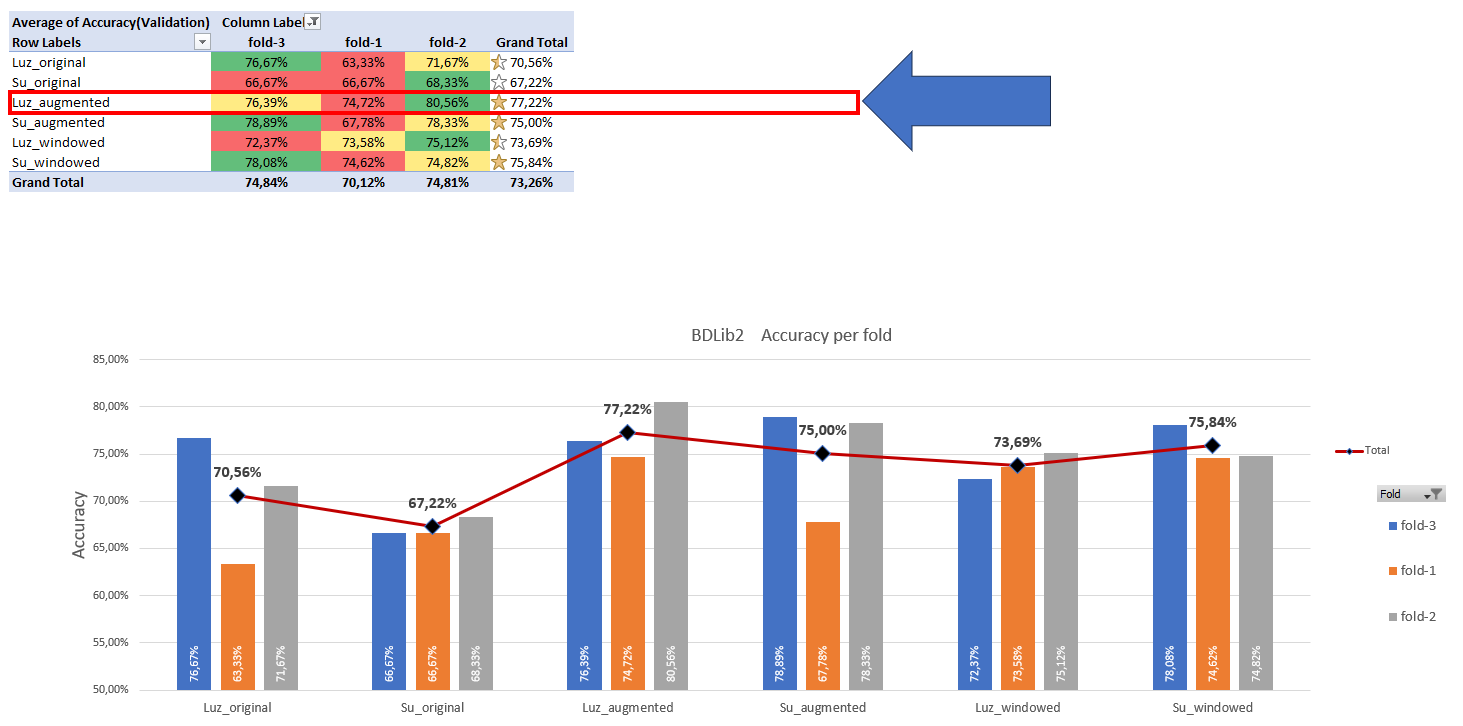

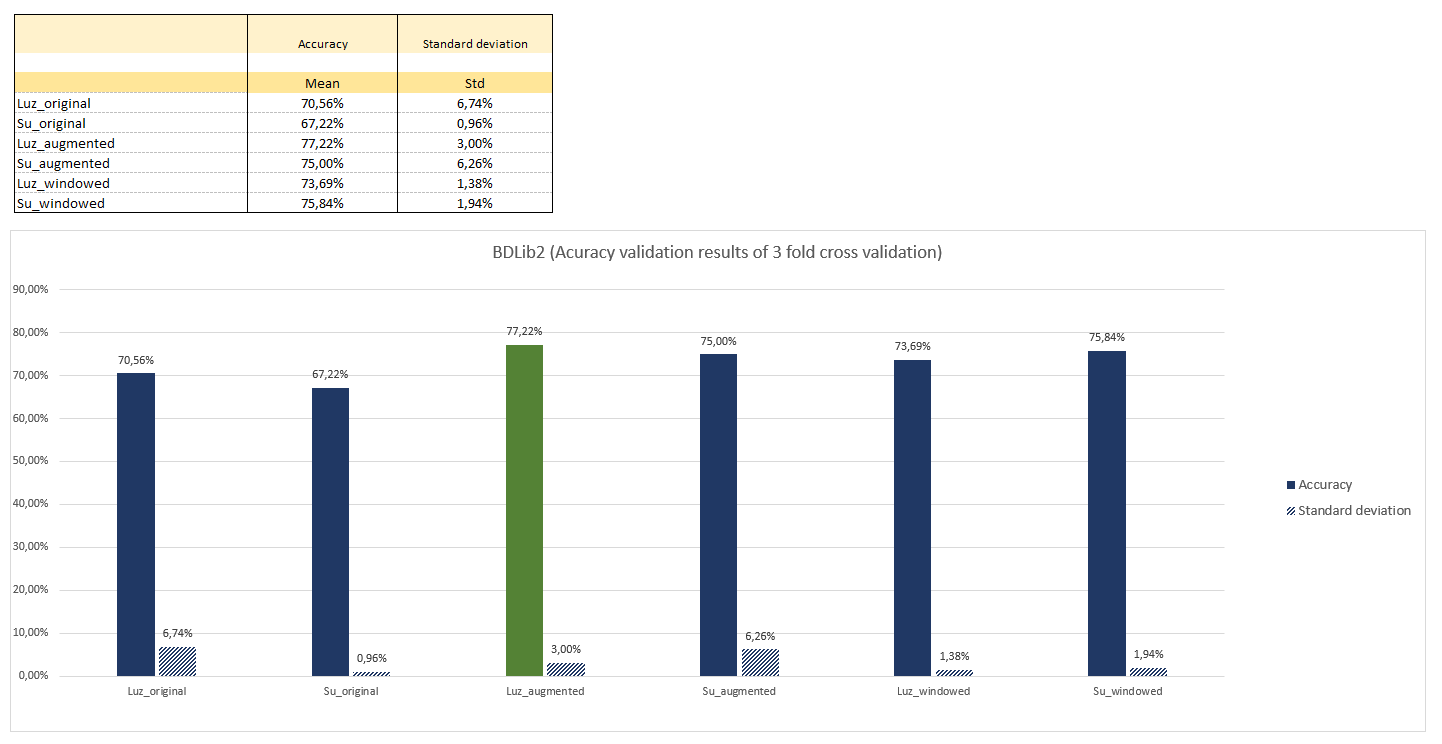

## Results US8K - Compiled in Excel

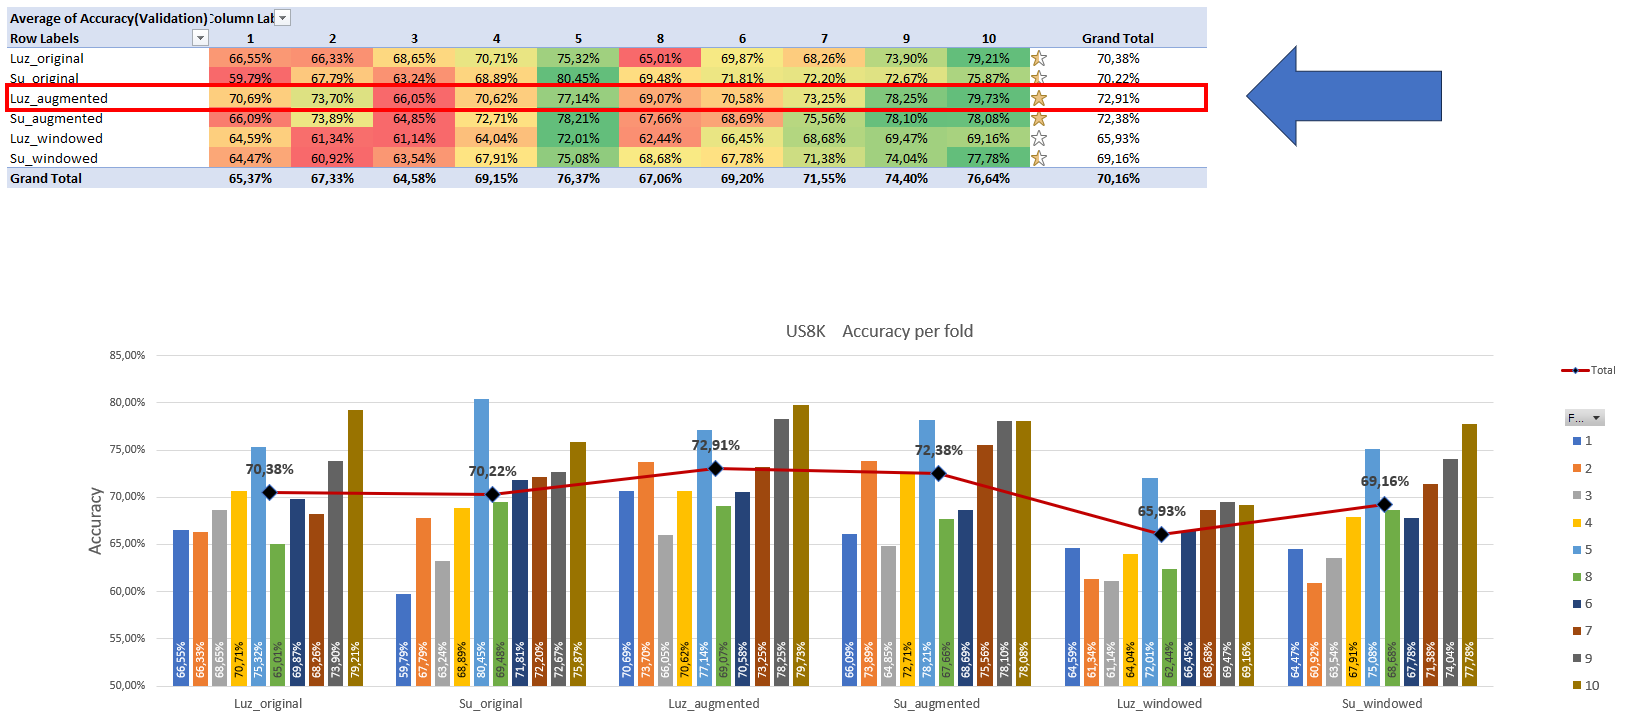

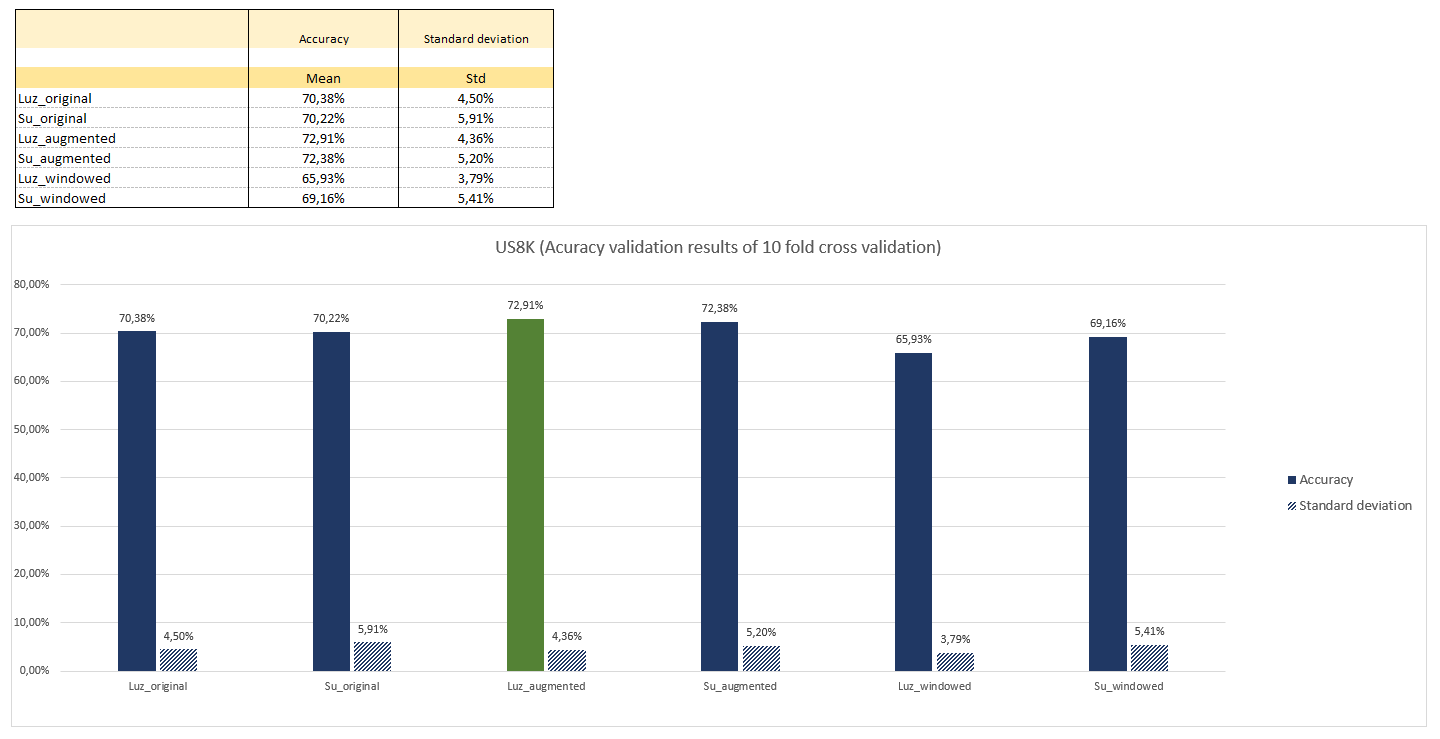

## Results US8K_AV - Compiled in Excel

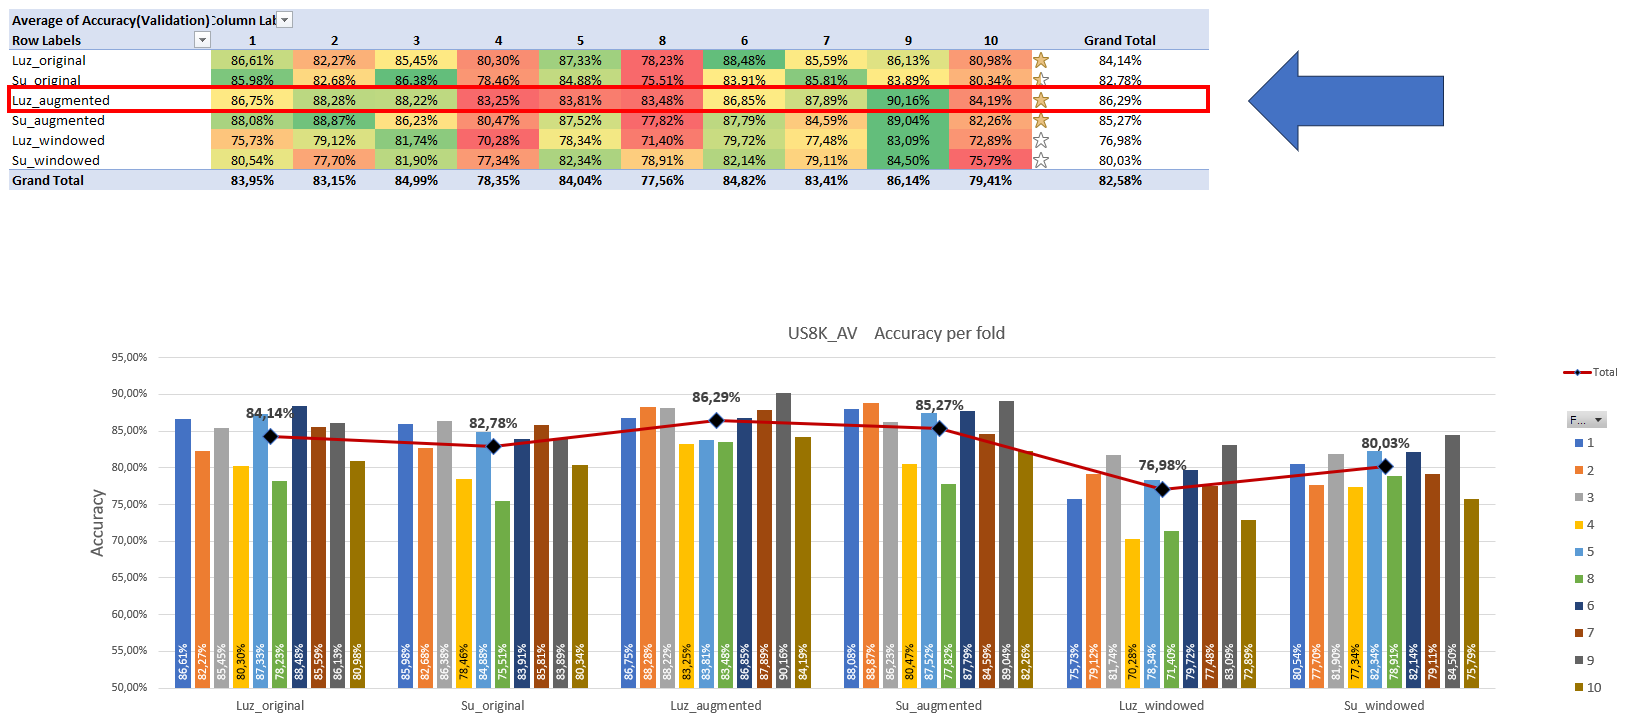

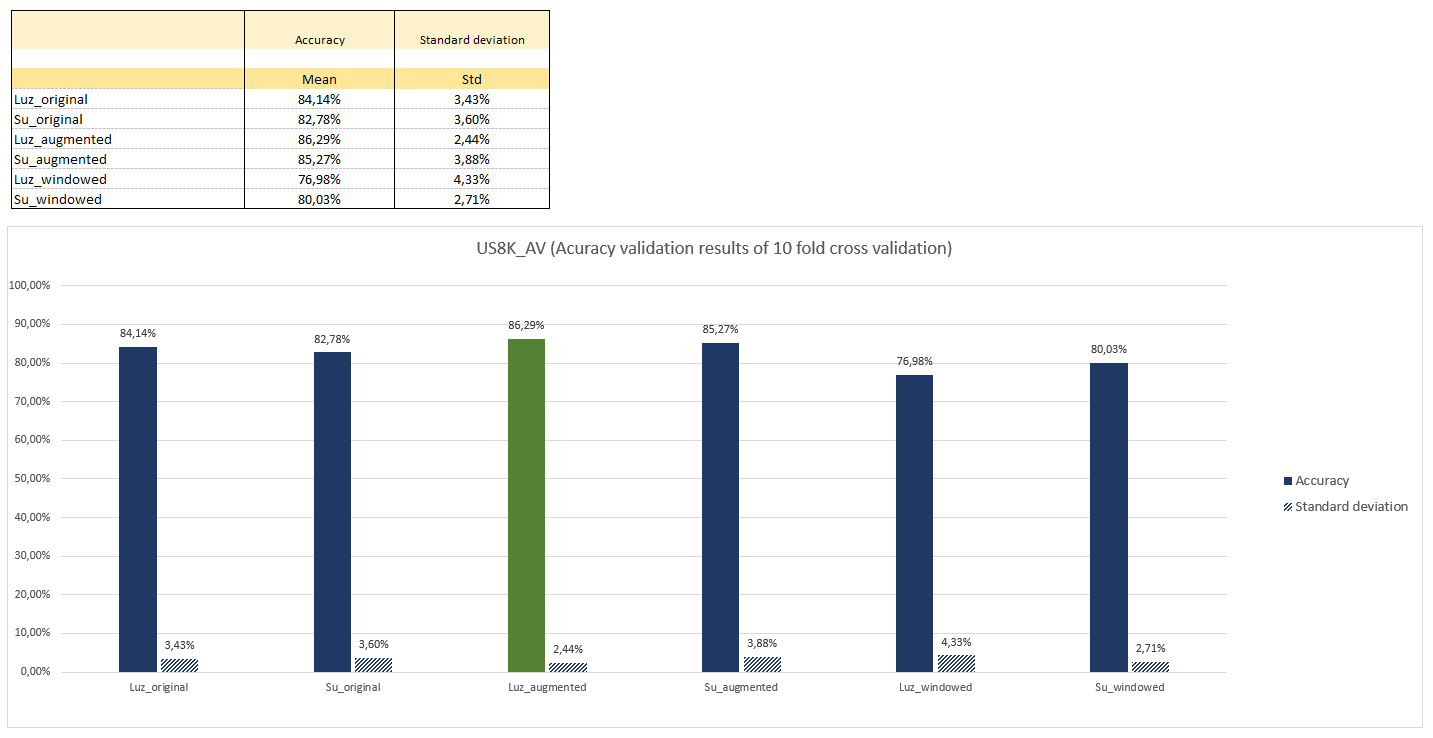

# End of the notebook